## Introduction

The company offers its customers two prepaid plans: Surf and Ultimate. The sales department wants to know which plan generates the most revenue so they can adjust their advertising budget.

You will conduct a preliminary analysis of the plans based on a relatively small customer selection. You will have data on 500 Megaline customers: who they are, where they are from, what plan they use, and the number of calls and text messages they sent in 2018. Your job is to analyze customer behavior and determine which prepaid plan generates the most revenue.

__Project Purpose__   
The main objective of this project is to analyze the behavior of a telecommunications provider's customers regarding calls, texts, and internet traffic. Using this data, the goal is to evaluate and compare the performance of two plan types (Surf and Ultimate) in terms of usage and revenue generation. This will allow you to provide strategic recommendations to optimize the plan offering and improve profitability.

Actions to be Executed   
- Data Loading and Cleaning: Identify and manage missing values, type conversions, and inconsistent data, including the use of pd.NA to maintain data integrity.
- Exploratory Data Analysis (EDA):
- Analyze monthly usage patterns for calls, messages, and traffic.
- Identify outliers using statistical methods (IQR).
- Examine differences by plan, city, and age group.
- Data Visualization: Generate charts such as histograms, KDEs, boxplots, and heatmaps to better understand the distribution of usage and user behavior.

__Planned Actions__

- Evaluate profitability by plan type, analyzing the revenue generated by each user and comparing it to the base rate.
- Reinforce interpretation of results, integrating findings on underutilization, potential improvements in plan design, and targeted marketing recommendations.

### Initialization

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
from scipy import stats as st
from IPython.display import display, HTML

pd.set_option('display.max_rows', 25) # show maximum 25 rows
pd.set_option('display.max_columns', 25) # show maximum 10 columns
pd.set_option('display.max_colwidth', 50) # show maximum 15 characters in each column
pd.set_option('display.width', 150) # Display up to 150 characters

### 1.2. Load Data

In [74]:
megaline_calls_path = '../data/raw/datasets/megaline_calls.csv'
megaline_internet_path = '../data/raw/datasets/megaline_internet.csv'
megaline_messages_path = '../data/raw/datasets/megaline_messages.csv'
megaline_plans_path = '../data/raw/datasets/megaline_plans.csv'
megaline_users_path = '../data/raw/datasets/megaline_users.csv'

In [75]:
df_calls = pd.read_csv(megaline_calls_path, header='infer', keep_default_na=False)
df_messages = pd.read_csv(megaline_messages_path, header='infer', keep_default_na=False)
df_plans = pd.read_csv(megaline_plans_path, header='infer', keep_default_na=False)
df_users = pd.read_csv(megaline_users_path, header='infer', keep_default_na=False)
df_internet = pd.read_csv(megaline_internet_path, header='infer', keep_default_na=False)

LSPL   
"keep_default_na=False" is used to later convert missing values to "pd.NA". This is beneficial because "pd.NA" provides:

- consistency across data types

- type integrity preservation

- cleaner logical operations

- improved control over missing data.

Since high performance or heavy computation is not required here, using "pd.NA" is appropriate.

### Functions

In [76]:
# Function used for detecting missing values ​​not treated as NAN due to the use of keep_defaukt_na=False
def missing_values_check(df): 
    
    missing_values = ['', ' ', 'N/A', 'none', 'None', 'null', 'NULL', 'NaN', 'nan', 'NAN', 'nat', 'NaT'] 

    for column in df.columns: 

        if df[column].isin(missing_values).any(): 

            print(f"> Null values in column '{column}': {df[column].isin(missing_values).sum()}") 

        else: 

            print(f"> There are no null values in column '{column}'")

# Function used for assigning pd.NA to missing values
def missing_values_replace(df): 

    missing_values = ['', ' ', 'N/A', 'none', 'None', 'null', 'NULL', 'NaN', 'nan', 'NAN', 'nat', 'NaT'] 

    for column in df.columns: 

        if df[column].isin(missing_values).any(): 

            df[column] = df[column].replace(missing_values, pd.NA) 

    return df

# Function for format normalizing type 'object' (strings)
def object_format_norm(df, include=None, exclude=None): 

    if exclude is None: 
        exclude = [] 

    if include is None: 
        available_columns = [col for col in df.columns if col not in exclude] 
    else: 
        available_columns = [col for col in include if col not in exclude] 

    for column in available_columns: 

        if df[column].dtype == 'object': 

            df[column] = df[column].str.lower() 
            df[column] = df[column].str.strip() 
            df[column] = df[column].str.replace(',', '') 
            df[column] = df[column].str.replace(' ', '_') 

        else: 

            continue 

    return df

# Function for calculating the income per user
def income(row, income_type='total'): 
    # Plan parameters 
    plans = { 
            'surf': { 
                     'base_fee': 20, 'minutes_limit': 500, 'messages_limit': 50, 'mb_limit': 15360, 
                     'minute_over': 0.03, 'message_over': 0.03, 'mb_over': 0.01 
                    }, 
            'ultimate': { 
                         'base_fee': 70, 'minutes_limit': 3000, 'messages_limit': 1000, 'mb_limit': 30720, 
                         'minute_over': 0.01, 'message_over': 0.01, 'mb_over': 0.007 
                        } 
            } 

    plan = plans[row['plan']] 

    # Calculate overages 
    income_duration = max(0, row['duration_month'] - plan['minutes_limit']) * plan['minute_over'] 
    income_messages = max(0, row['messages_count'] - plan['messages_limit']) * plan['message_over'] 
    income_traffic = max(0, row['traffic_count'] - plan['mb_limit']) * plan['mb_over'] 

    if income_type == 'duration': 
        return plan['base_fee'] + income_duration 
    elif income_type == 'messages': 
        return plan['base_fee'] + income_messages 
    elif income_type == 'traffic': 
        return plan['base_fee'] + income_traffic 
    elif income_type == 'total': 
        return plan['base_fee'] + income_duration + income_messages + income_traffic 
    else: 
        raise ValueError(f"Invalid income_type: {income_type}")

def outlier_limit_bounds(df, column, bound='both'): 

    q1 = df[column].quantile(0.25) 
    q3 = df[column].quantile(0.75) 

    iqr = q3 - q1 
    lower_bound = q1 - 1.5 * iqr 
    upper_bound = q3 + 1.5 * iqr 

    if bound == 'both': 

        df_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)] 
        print(f"> Lower bound of outliers for column '{column}': {lower_bound}") 
        print(f"> Upper bound of outliers for column '{column}': {upper_bound}") 
        return df_outliers 

    elif bound =='upper': 

        df_outliers = df[(df[column] > upper_bound)] 
        print(f"> Upper bound of outliers for column '{column}': {upper_bound}") 
        return df_outliers 

    elif bound =='lower': 

        df_outliers = df[(df[column] < lower_bound)] 
        print(f"> Lower bound of outliers for column '{column}': {lower_bound}") 
        return df_outliers 

    else: 
        print(f"> Wrong limit type, correct values ​​available: 'both', 'upper' or 'lower'")
        

### 1.4. Prepare the data
[The data for this project is divided into several tables. Explore each one to get an initial understanding of the data. If necessary, make any necessary corrections to each table.]

### 1.5. Rates

In [77]:
# Prints general/summary information about the rates DataFrame

df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [78]:
# Print a sample of the rate data

print(df_plans.head())

   messages_included  mb_per_month_included  minutes_included  usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0                 50                  15360               500               20          10             0.03            0.03        surf
1               1000                  30720              3000               70           7             0.01            0.01    ultimate


[Describe what you see and observe in the general information and the printed data sample for the above data price. Are there any issues (inappropriate data types, missing data, etc.) that might require further investigation and changes? How can they be fixed?]

`LSPL`     
> There are no values ​​that need to be corrected or enriched.

### 1.6. Correct Data

[Correct obvious problems with the data based on your initial observations.]

### 1.7. Enrich the data

[Add additional factors to the data if you think they might be useful.]

### 1.8. Users

In [79]:
# Prints general/summary information about the users DataFrame

df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [80]:
# Print a sample of data for users

print(df_users.sample(25, random_state=333))

     user_id first_name  last_name  age                                              city    reg_date      plan  churn_date
315     1315       Mora  Schroeder   45                              Raleigh-Cary, NC MSA  2018-04-26      surf  2018-10-03
174     1174     Larisa      Ellis   67                          Cleveland-Elyria, OH MSA  2018-01-28      surf            
153     1153  Kathaleen   Crawford   30               Bridgeport-Stamford-Norwalk, CT MSA  2018-06-19      surf            
154     1154   Humberto     Pruitt   53  Nashville-Davidson–Murfreesboro–Franklin, TN MSA  2018-07-18  ultimate            
276     1276     Karmen     Carney   20                     Phoenix-Mesa-Chandler, AZ MSA  2018-02-14      surf            
391     1391      Errol      Cooke   52         New York-Newark-Jersey City, NY-NJ-PA MSA  2018-09-11  ultimate            
33      1033    Latoyia      Moran   28                             Oklahoma City, OK MSA  2018-05-30  ultimate            
5       

[Describe what you see and observe in the overview and the printed data sample for the data price above. Are there any issues (unsuitable data types, missing data, etc.) that might require further investigation and changes? How can they be fixed?]

`LSPL`   
> "There are missing values ​​and also values ​​that need to be converted to the datetime data type. Both are in the same column. When performing the conversion, pandas will automatically handle the missing data and convert it to NAT."

1.8.1. Correct the data

[Correct obvious problems with the data based on your initial observations.]

In [81]:
print(f"> Explicit duplicates: {df_users.duplicated().sum()}")

> Explicit duplicates: 0


In [82]:
missing_values_check(df_users)

> There are no null values in column 'user_id'
> There are no null values in column 'first_name'
> There are no null values in column 'last_name'
> There are no null values in column 'age'
> There are no null values in column 'city'
> There are no null values in column 'reg_date'
> There are no null values in column 'plan'
> Null values in column 'churn_date': 466


In [83]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

In [84]:
df_users = missing_values_replace(df_users)

In [85]:
print(f"> Null values ​​NA: \n\n{df_users.isna().sum()}")

> Null values ​​NA: 

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64


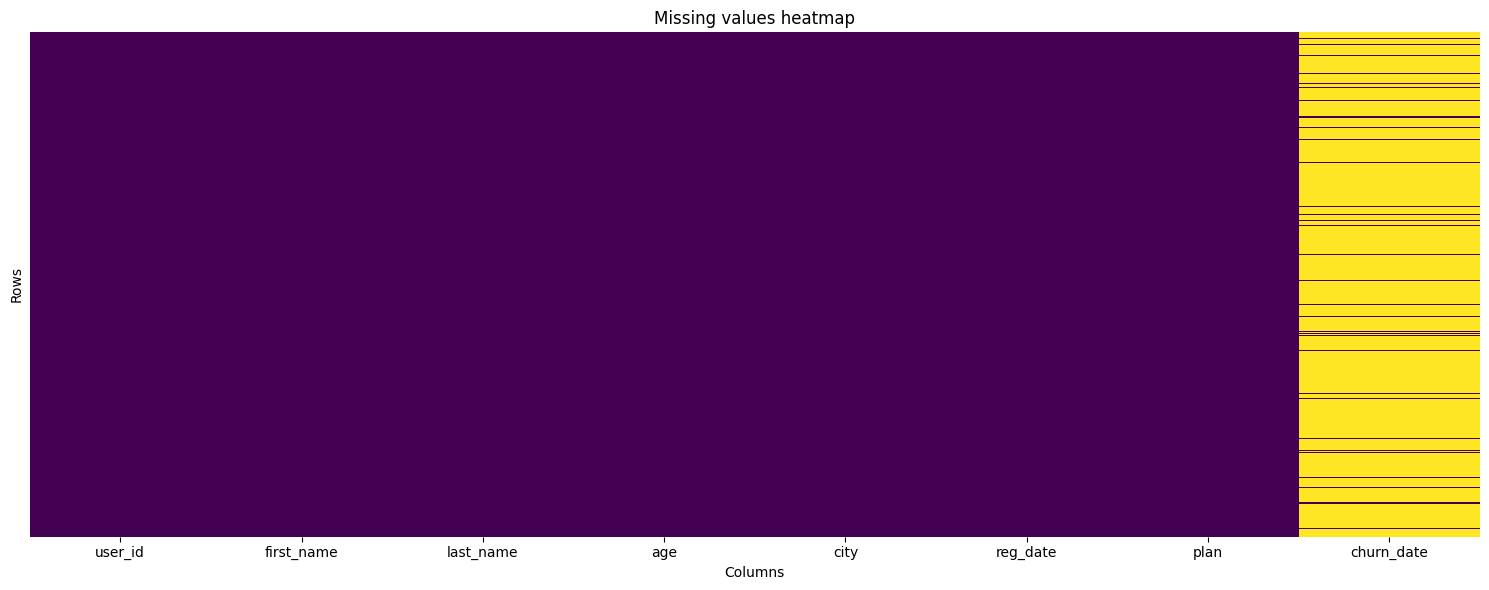

In [86]:
plt.figure(figsize=(15, 6))
sns.heatmap(df_users.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing values heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.tight_layout()
plt.show()

In [87]:
df_users = object_format_norm(df_users)

In [88]:
df_users.info()
print()
print(df_users.sample(25, random_state=333))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB

     user_id first_name  last_name  age                                             city   reg_date      plan churn_date
315     1315       mora  schroeder   45                              raleigh-cary_nc_msa 2018-04-26      surf 2018-10-03
174     1174     larisa      ellis   67                          cleveland-elyria_oh_msa 2018-01-28    

### 1.8.2. Enrich the data

[Add additional factors to the data if you think they might be useful.]

`LSPL`   
> The 'first_name' and 'last_name' columns have been removed after being combined into the new 'full_name' column. This merging makes it easier to identify duplicate users in the dataset.

In [89]:
df_users['full_name'] = df_users['first_name'] + '_' + df_users['last_name']

In [90]:
print(f"Number of unique users: {df_users['full_name'].nunique()}")

Number of unique users: 500


In [91]:
df_users = df_users.drop(labels=['first_name', 'last_name'], axis=1)

In [92]:
print(df_users.sample(25))

     user_id  age                                             city   reg_date      plan churn_date          full_name
132     1132   39            san_francisco-oakland-berkeley_ca_msa 2018-04-14  ultimate        NaT     edward_roberts
386     1386   30                   seattle-tacoma-bellevue_wa_msa 2018-04-11      surf        NaT       jeni_gilbert
351     1351   47                 san_antonio-new_braunfels_tx_msa 2018-09-05  ultimate        NaT        kyle_grimes
155     1155   19     miami-fort_lauderdale-west_palm_beach_fl_msa 2018-02-21  ultimate        NaT        claude_hahn
428     1428   66                     phoenix-mesa-chandler_az_msa 2018-10-23      surf        NaT    asuncion_conrad
36      1036   70                    denver-aurora-lakewood_co_msa 2018-05-09  ultimate        NaT        myron_hodge
449     1449   39                   seattle-tacoma-bellevue_wa_msa 2018-10-04      surf        NaT        boyd_kelley
30      1030   30            chicago-naperville-elgin_il

### 1.9. Calls

In [93]:
# Prints general/summary information about the calls' DataFrame

df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [94]:
# Print a sample of data for the calls

print(df_calls.sample(25, random_state=333))

              id  user_id   call_date  duration
128293  1460_404     1460  2018-09-06      3.27
1429     1008_70     1008  2018-12-08      0.00
31689     1120_5     1120  2018-06-10      4.89
18121   1069_590     1069  2018-12-19      3.45
92312   1331_203     1331  2018-12-14      8.97
27042   1101_369     1101  2018-04-30      2.72
25451   1098_125     1098  2018-11-20      9.26
53580   1192_716     1192  2018-11-05     14.99
33578   1126_301     1126  2018-08-26      0.00
71040   1252_506     1252  2018-09-12      6.87
66919   1240_777     1240  2018-10-21      7.07
109880  1387_252     1387  2018-10-22     13.56
25544   1098_225     1098  2018-09-13     12.97
36258   1138_212     1138  2018-05-05      0.00
44287   1160_303     1160  2018-09-03     14.01
66560   1240_418     1240  2018-12-06     11.71
76253   1270_166     1270  2018-10-02      0.00
18353   1071_122     1071  2018-09-16      0.00
31555   1119_196     1119  2018-10-31      7.42
3170     1011_23     1011  2018-08-14   

[Describe what you see and observe in the overview and the printed data sample for the data price above. Are there any issues (inappropriate data types, missing data, etc.) that might require further investigation and changes? How can they be fixed?]

`LSPL`   
> The values ​​in this column should be converted to datetime type. This is essential for further analysis such as time sorting, date filtering, and trend visualization.

### 1.9.1. Correct the data

In [95]:
print(f"> Explicit Duplicates: {df_calls.duplicated().sum()}")

> Explicit Duplicates: 0


[Correct obvious problems with the data based on initial observations.]

In [96]:
missing_values_check(df_calls)

> There are no null values in column 'id'
> There are no null values in column 'user_id'
> There are no null values in column 'call_date'
> There are no null values in column 'duration'


In [97]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')

In [98]:
df_calls.info()
print()
print(df_calls.sample(25, random_state=333))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB

              id  user_id  call_date  duration
128293  1460_404     1460 2018-09-06      3.27
1429     1008_70     1008 2018-12-08      0.00
31689     1120_5     1120 2018-06-10      4.89
18121   1069_590     1069 2018-12-19      3.45
92312   1331_203     1331 2018-12-14      8.97
27042   1101_369     1101 2018-04-30      2.72
25451   1098_125     1098 2018-11-20      9.26
53580   1192_716     1192 2018-11-05     14.99
33578   1126_301     1126 2018-08-26      0.00
71040   1252_506     1252 2018-09-12      6.87
669

### 1.9.2. Enrich the data

[Add additional factors to the data if you think they might be useful.]

### 1.10. Messages

In [99]:
# Prints general/summary information about the messages' DataFrame

df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [100]:
# Print a sample of data for the messages

print(df_messages.sample(25, random_state=333))

             id  user_id message_date
39510   1257_63     1257   2018-06-18
8515   1061_521     1061   2018-05-29
12281   1081_20     1081   2018-10-04
30468  1192_288     1192   2018-10-15
29551  1181_246     1181   2018-11-03
37713  1249_254     1249   2018-08-02
52968  1339_102     1339   2018-07-15
20633  1130_308     1130   2018-10-19
70285  1456_252     1456   2018-08-18
3009    1033_22     1033   2018-11-27
28505  1174_295     1174   2018-06-08
6319   1055_437     1055   2018-08-16
49786  1328_744     1328   2018-09-22
45134   1303_53     1303   2018-12-26
2168    1028_73     1028   2018-10-30
4301   1043_471     1043   2018-06-21
13827   1094_98     1094   2018-12-05
27575   1172_32     1172   2018-12-23
50506  1329_532     1329   2018-09-14
32448   1203_93     1203   2018-09-03
66853  1434_408     1434   2018-07-12
10891  1077_162     1077   2018-11-04
71152  1464_320     1464   2018-12-08
22741  1136_184     1136   2018-10-26
25219   1151_62     1151   2018-10-08


[Describe what you see and observe in the overview and the printed data sample for the data price above. Are there any issues (inappropriate data types, missing data, etc.) that might require further investigation and changes? How can they be fixed?]

`LSPL`   
> The values ​​in this column should be converted to datetime type. This is essential for further analysis such as time sorting, date filtering, and trend visualization.

### 1.10.1. Correct the data

[Correct obvious problems with the data based on your initial observations.]

In [101]:
print(f"> Explicit duplicates: {df_messages.duplicated().sum()}")

> Explicit duplicates: 0


In [102]:
missing_values_check(df_messages)

> There are no null values in column 'id'
> There are no null values in column 'user_id'
> There are no null values in column 'message_date'


In [103]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')

In [104]:
df_messages.info()
print()
print(df_messages.sample(25, random_state=333))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB

             id  user_id message_date
39510   1257_63     1257   2018-06-18
8515   1061_521     1061   2018-05-29
12281   1081_20     1081   2018-10-04
30468  1192_288     1192   2018-10-15
29551  1181_246     1181   2018-11-03
37713  1249_254     1249   2018-08-02
52968  1339_102     1339   2018-07-15
20633  1130_308     1130   2018-10-19
70285  1456_252     1456   2018-08-18
3009    1033_22     1033   2018-11-27
28505  1174_295     1174   2018-06-08
6319   1055_437     1055   2018-08-16
49786  1328_744     1328   2018-09-22
45134   1303_53     1303   2018-12-26
21

[Describe what you see and observe in the general information and the printed data sample for the above data price. Are there any issues (inappropriate data types, missing data, etc.) that might require further investigation and changes? How can they be fixed?]

`LSPL`   
> The "id" column name will be changed to "session_id" to avoid confusion. There are values ​​that should be converted to datetime data type.

### 1.11.1. Correct the data

[Correct obvious problems with the data based on your initial observations.]

In [105]:
df_internet = df_internet.rename(columns={'id' : 'session_id'})

In [106]:
print(f"> Explicit Duplicates: {df_internet.duplicated().sum()}")

> Explicit Duplicates: 0


In [107]:
missing_values_check(df_internet)

> There are no null values in column 'session_id'
> There are no null values in column 'user_id'
> There are no null values in column 'session_date'
> There are no null values in column 'mb_used'


In [108]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')

In [109]:
df_internet.info()
print()
print(df_internet.sample(25, random_state=333))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   session_id    104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB

       session_id  user_id session_date  mb_used
5848       1032_9     1032   2018-12-17   794.45
16371    1073_305     1073   2018-06-14   440.29
73192     1343_48     1343   2018-10-25   439.81
67418     1313_92     1313   2018-08-09   549.25
71612    1334_180     1334   2018-07-01   290.71
136      1001_251     1001   2018-12-04   695.82
5794     1031_472     1031   2018-10-14    38.98
70727    1330_200     1330   2018-12-22     0.00
12842    1061_339     1061   2018-06-17   492.29
103423    14

### 1.11.2. Enrich the data

[Add additional factors to the data if you think they might be useful.]

### 1.12. Study the pricing terms and conditions

[It's extremely important to understand how the rates work and how users are charged based on their subscription plan. Therefore, we suggest printing the pricing information to review its terms and conditions.]

In [110]:
users_plan = df_users.groupby('plan')['user_id'].count()
users_plan.name = 'amount_users'
print(f"> Number of users per plan: \n\n{users_plan}")

> Number of users per plan: 

plan
surf        339
ultimate    161
Name: amount_users, dtype: int64


In [111]:
# Print the rate conditions and make sure they are clear to you

print(df_plans)

   messages_included  mb_per_month_included  minutes_included  usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0                 50                  15360               500               20          10             0.03            0.03        surf
1               1000                  30720              3000               70           7             0.01            0.01    ultimate


### 1.13. Aggregate data by user

[Now that the data is clean, aggregate the data by user and by period so that there is only one record per user per period. This will make further analysis much easier.]

In [112]:
# Calculate the number of calls made by each user per month. Save the result.

df_calls['call_month'] = df_calls['call_date'].dt.to_period('M')

In [184]:
user_calls_per_month = df_calls.groupby(['user_id', 'call_month'])['id'].count()
user_calls_per_month.name = 'calls_count'
print(user_calls_per_month)
print()
print("> Missing values: ", user_calls_per_month.isna().sum())

user_id  call_month
1000     2018-12       16
1001     2018-08       27
         2018-09       49
         2018-10       65
         2018-11       64
                       ..
1498     2018-12       39
1499     2018-09       41
         2018-10       53
         2018-11       45
         2018-12       65
Name: calls_count, Length: 2258, dtype: int64

> Missing values:  0


In [114]:
# Calculate the number of minutes used by each user per month. Save the result.

user_duration_per_month = df_calls.groupby(['user_id', 'call_month'])['duration'].sum()
user_duration_per_month.name = 'duration_month'
print(user_duration_per_month)
print()
print("> Missing values: ", user_duration_per_month.isna().sum())

user_id  call_month
1000     2018-12       116.83
1001     2018-08       171.14
         2018-09       297.69
         2018-10       374.11
         2018-11       404.59
                        ...  
1498     2018-12       324.77
1499     2018-09       330.37
         2018-10       363.28
         2018-11       288.56
         2018-12       468.10
Name: duration_month, Length: 2258, dtype: float64

> Missing values:  0


In [ ]:
# Calculate the number of messages sent by each user per month. Save the result.

df_messages['message_month'] = df_messages['message_date'].dt.to_period('M')

In [116]:
user_messages_per_month = df_messages.groupby(['user_id', 'message_month'])['id'].count()
user_messages_per_month.name = 'messages_count'
print(user_messages_per_month)
print()
print("> Missing values: ", user_messages_per_month.isna().sum())

user_id  message_month
1000     2018-12          11
1001     2018-08          30
         2018-09          44
         2018-10          53
         2018-11          36
                          ..
1496     2018-09          21
         2018-10          18
         2018-11          13
         2018-12          11
1497     2018-12          50
Name: messages_count, Length: 1806, dtype: int64

> Missing values:  0


In [117]:
# Calculate the amount of internet traffic used by each user per month. Save the result.

df_internet['traffic_month'] = df_internet['session_date'].dt.to_period('M')

In [118]:
user_traffic_per_month = df_internet.groupby(['user_id', 'traffic_month'])['mb_used'].sum()
user_traffic_per_month.name = 'traffic_count'
print(user_traffic_per_month)
print()
print("> Missing values: ", user_traffic_per_month.isna().sum())

user_id  traffic_month
1000     2018-12           1901.47
1001     2018-08           6919.15
         2018-09          13314.82
         2018-10          22330.49
         2018-11          18504.30
                            ...   
1498     2018-12          23137.69
1499     2018-09          12984.76
         2018-10          19492.43
         2018-11          16813.83
         2018-12          22059.21
Name: traffic_count, Length: 2277, dtype: float64

> Missing values:  0


[Put the aggregated data together in a DataFrame so that there is one record that represents what a unique user consumed in a given month.]

In [119]:
# Merge call, minute, message and internet data based on user_id and month

df_user_activity_per_month = pd.concat([user_calls_per_month, user_duration_per_month, 
user_messages_per_month, user_traffic_per_month], axis=1)

df_user_activity_per_month = df_user_activity_per_month.reset_index()
df_user_activity_per_month = df_user_activity_per_month.rename(columns={'level_1': 'month'})

print(df_user_activity_per_month.sample(25, random_state=333))
print()
print("> Missing values:\n", df_user_activity_per_month.isna().sum())

      user_id    month  calls_count  duration_month  messages_count  traffic_count
2084     1460  2018-07         50.0          381.65            44.0       29541.12
262      1060  2018-09         92.0          624.89            66.0       26256.75
1266     1276  2018-11         54.0          408.76            19.0       10918.63
695      1150  2018-12         76.0          455.45             NaN       12881.10
833      1179  2018-07         21.0          172.94             4.0        1473.95
1732     1382  2018-07        163.0         1029.27            52.0       13018.42
1806     1397  2018-07        121.0          898.44             NaN       24072.19
682      1147  2018-09         89.0          532.19            18.0       35929.97
171      1043  2018-10         24.0          179.50            87.0       31327.21
126      1036  2018-06         19.0          152.25            19.0        1449.37
2085     1460  2018-08         70.0          516.73            42.0       29968.06
1969

In [120]:
df_user_activity_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype    
---  ------          --------------  -----    
 0   user_id         2293 non-null   int64    
 1   month           2293 non-null   period[M]
 2   calls_count     2258 non-null   float64  
 3   duration_month  2258 non-null   float64  
 4   messages_count  1806 non-null   float64  
 5   traffic_count   2277 non-null   float64  
dtypes: float64(4), int64(1), period[M](1)
memory usage: 107.6 KB


`LSPL`   
> Null values ​​(NA) exist after merging the previously created series for the total service usage calculation. Therefore, these values ​​will be replaced with (0.0) for columns with quantitative values.

In [121]:
for column in df_user_activity_per_month.columns:
    
    if column == 'user_id' or column == 'month':
        continue
    else:
        df_user_activity_per_month[column] = df_user_activity_per_month[column].fillna(0.00)

print()
print("> Missing values:\n\n", df_user_activity_per_month.isna().sum())


> Missing values:

 user_id           0
month             0
calls_count       0
duration_month    0
messages_count    0
traffic_count     0
dtype: int64


In [122]:
# Add rate information

df_user_activity_per_month = df_user_activity_per_month.merge(df_users[['user_id', 'plan']], on='user_id', how='left')

print(df_user_activity_per_month.sample(25, random_state=333))

      user_id    month  calls_count  duration_month  messages_count  traffic_count      plan
2084     1460  2018-07         50.0          381.65            44.0       29541.12  ultimate
262      1060  2018-09         92.0          624.89            66.0       26256.75      surf
1266     1276  2018-11         54.0          408.76            19.0       10918.63      surf
695      1150  2018-12         76.0          455.45             0.0       12881.10  ultimate
833      1179  2018-07         21.0          172.94             4.0        1473.95      surf
1732     1382  2018-07        163.0         1029.27            52.0       13018.42  ultimate
1806     1397  2018-07        121.0          898.44             0.0       24072.19      surf
682      1147  2018-09         89.0          532.19            18.0       35929.97      surf
171      1043  2018-10         24.0          179.50            87.0       31327.21  ultimate
126      1036  2018-06         19.0          152.25            19.0   

[Calculate monthly revenue per user (subtract the free plan limit from the total number of calls, texts, and data; multiply the result by the calling plan value; add the monthly fee based on the calling plan). Note: Given the plan terms, this might not be as trivial as a couple of lines! So it's okay to spend some time on it.]

In [123]:
# Calculate the monthly revenue for each user

print(df_user_activity_per_month.describe())

           user_id  calls_count  duration_month  messages_count  traffic_count
count  2293.000000  2293.000000     2293.000000     2293.000000    2293.000000
mean   1246.075883    60.067597      405.211627       33.166594   16764.397606
std     143.051927    32.402563      223.383523       34.070085    7967.237527
min    1000.000000     0.000000        0.000000        0.000000       0.000000
25%    1122.000000    38.000000      249.130000        3.000000   12235.760000
50%    1245.000000    60.000000      400.160000       26.000000   16830.640000
75%    1368.000000    79.000000      540.450000       51.000000   20999.840000
max    1499.000000   205.000000     1431.220000      266.000000   70931.590000


In [124]:
df_user_activity_per_month['monthly_income'] = 0


In [125]:
df_user_activity_per_month['monthly_income'] = df_user_activity_per_month.apply(lambda row: income(row), axis=1)

In [126]:
print(df_user_activity_per_month.sample(25))

      user_id    month  calls_count  duration_month  messages_count  traffic_count      plan  monthly_income
1044     1225  2018-12         65.0          467.30             0.0       14304.55      surf         20.0000
853      1182  2018-09         23.0          203.36             4.0       17325.10      surf         39.6510
1699     1373  2018-09         56.0          375.27            27.0        9103.43  ultimate         70.0000
732      1156  2018-12         48.0          377.51             0.0       17486.49      surf         41.2649
1836     1401  2018-12         97.0          596.26            69.0        8407.64  ultimate         70.0000
2268     1131  2018-06          0.0            0.00            27.0       14637.04      surf         20.0000
215      1052  2018-11         27.0          197.32            52.0        4650.40      surf         20.0600
852      1182  2018-08         27.0          193.79             2.0       19038.13      surf         56.7813
1306     1285  2018

### 1.14. Study User Behavior
[Calculate some useful descriptive statistics for the aggregated and merged data that show a general overview captured by the data. Draw useful graphs to facilitate understanding. Since the main task is to compare rates and decide which is more cost-effective, the statistics and graphs should be calculated by rate.]

[In the comments, you will find relevant clues for calls, but there are none for messages and the Internet. However, the principle of the statistical study applied to them is the same as for calls.]

### 1.14.1. Calls

In [127]:
print(df_user_activity_per_month['duration_month'].describe())

count    2293.000000
mean      405.211627
std       223.383523
min         0.000000
25%       249.130000
50%       400.160000
75%       540.450000
max      1431.220000
Name: duration_month, dtype: float64


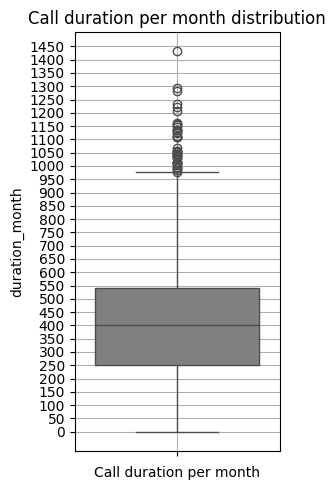

In [128]:
plt.figure(figsize=(3, 5))
sns.boxplot(y='duration_month', data=df_user_activity_per_month, color='grey')

plt.xlabel('Call duration per month')
plt.title('Call duration per month distribution')
plt.grid(True)
plt.yticks(range(0, 1500, 50), rotation=0)

plt.tight_layout()
plt.show()

In [129]:
df_duration_outliers = outlier_limit_bounds(df_user_activity_per_month, 'duration_month', bound='upper')


> Upper bound of outliers for column 'duration_month': 977.4300000000001


In [130]:
outliers_duration_user_id = df_duration_outliers['user_id'].unique()

print(f"> Users identified as outliers for column 'duration_month':\n\n{outliers_duration_user_id}")

> Users identified as outliers for column 'duration_month':

[1003 1014 1052 1057 1126 1141 1159 1215 1240 1267 1320 1324 1326 1329
 1334 1365 1379 1382 1412 1479]


In [131]:
df_ol_d_users = df_users.loc[(df_users['user_id']).isin(outliers_duration_user_id), :]

`LSPL`   
> Descriptive statistics for users identified as outliers.

In [132]:
print(df_ol_d_users[['user_id', 'age']].describe())

           user_id       age
count    20.000000  20.00000
mean   1246.200000  45.10000
std     142.430999  17.86175
min    1003.000000  18.00000
25%    1137.250000  31.25000
50%    1293.500000  48.00000
75%    1341.750000  61.00000
max    1479.000000  70.00000


In [133]:
print(df_ol_d_users.describe(include=['object']))

                                            city  plan         full_name
count                                         20    20                20
unique                                        17     2                20
top     new_york-newark-jersey_city_ny-nj-pa_msa  surf  reynaldo_jenkins
freq                                           3    14                 1


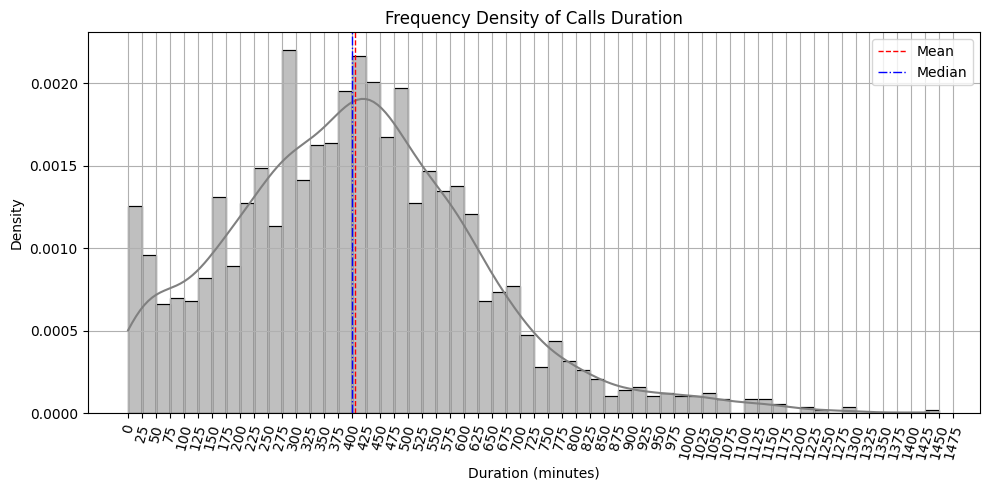

In [134]:
duration = df_user_activity_per_month['duration_month'].dropna()
mean = duration.mean()
median = duration.median()

bins = np.arange(0, 1475, 25)

plt.figure(figsize=(10, 5))

sns.histplot(duration, bins=bins, kde=True, stat="density", color='grey')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='blue', linestyle='-.', linewidth=1, label='Median')
plt.title('Frequency Density of Calls Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Density')
plt.grid(True)
plt.xticks(range(0, 1480, 25), rotation=75)
plt.legend()

plt.tight_layout()
plt.show()

In [135]:
# Compare the average call duration for each plan and each month. Plot a bar chart to visualize it.

df_median_duration_calls_per_plan_month = df_user_activity_per_month.pivot_table(index='plan', columns='month',
                                                                                 values='duration_month', aggfunc='median')
print(df_median_duration_calls_per_plan_month)

month     2018-01  2018-02  2018-03  2018-04  2018-05  2018-06  2018-07  2018-08  2018-09  2018-10  2018-11  2018-12
plan                                                                                                                
surf      192.840   240.66   312.79   320.12   387.45   400.28   430.06   367.11   401.52   407.59   392.10  424.385
ultimate  221.425   398.33   236.39   283.54   385.48   377.24   403.42   388.24   410.15   430.64   409.65  414.360


In [136]:
df_median_duration_calls_per_plan_month = df_median_duration_calls_per_plan_month.reset_index().melt(
    id_vars='plan',
    var_name='month',
    value_name='median_duration'
)

print(df_median_duration_calls_per_plan_month)

        plan    month  median_duration
0       surf  2018-01          192.840
1   ultimate  2018-01          221.425
2       surf  2018-02          240.660
3   ultimate  2018-02          398.330
4       surf  2018-03          312.790
5   ultimate  2018-03          236.390
6       surf  2018-04          320.120
7   ultimate  2018-04          283.540
8       surf  2018-05          387.450
9   ultimate  2018-05          385.480
10      surf  2018-06          400.280
11  ultimate  2018-06          377.240
12      surf  2018-07          430.060
13  ultimate  2018-07          403.420
14      surf  2018-08          367.110
15  ultimate  2018-08          388.240
16      surf  2018-09          401.520
17  ultimate  2018-09          410.150
18      surf  2018-10          407.590
19  ultimate  2018-10          430.640
20      surf  2018-11          392.100
21  ultimate  2018-11          409.650
22      surf  2018-12          424.385
23  ultimate  2018-12          414.360


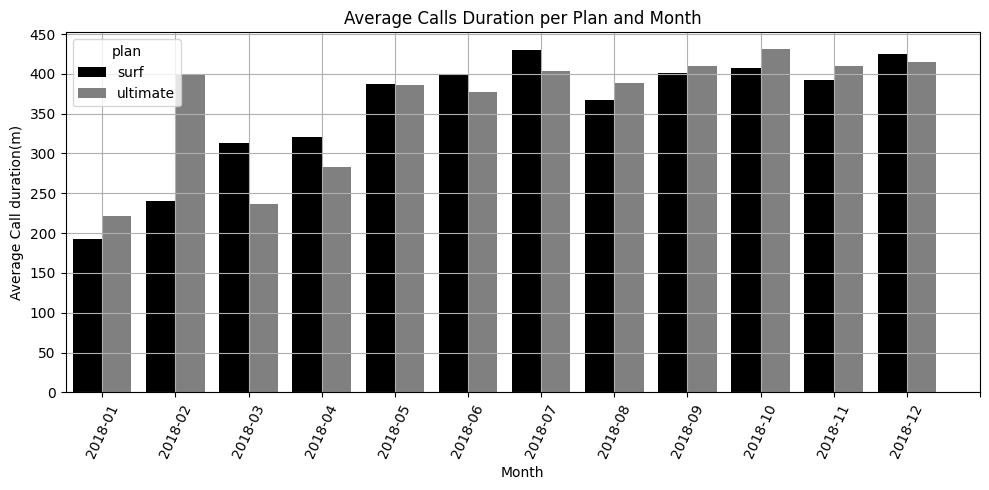

In [137]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_median_duration_calls_per_plan_month, x='month', y='median_duration', hue='plan', palette=['black', 'grey'])

plt.xlabel('Month')
plt.ylabel('Average Call duration(m)')
plt.title('Average Calls Duration per Plan and Month')
plt.grid(True)
plt.xticks(range(0, 13, 1), rotation=65)
plt.yticks(range(0, 500, 50))

plt.tight_layout()
plt.show()

In [138]:
median_duration_surf = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'surf'), 'duration_month'].median()
median_duration_ultimate = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'ultimate'), 'duration_month'].median()

print(f"> Average call duration for plan (Surf): {median_duration_surf:.2f}")
print(f"> Average call duration for plan (Ultimate): {median_duration_ultimate:.2f}")

> Average call duration for plan (Surf): 401.76
> Average call duration for plan (Ultimate): 398.59


In [139]:
# Compare the number of monthly minutes that users of each plan need. Plot a histogram.

surf_duration = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'surf'), 'duration_month']
ultimate_duration = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'ultimate'), 'duration_month']

print(surf_duration)
print()
print(ultimate_duration)

1       171.14
2       297.69
3       374.11
4       404.59
5       392.93
         ...  
2282      0.00
2286      0.00
2287      0.00
2288      0.00
2289      0.00
Name: duration_month, Length: 1573, dtype: float64

0       116.83
19        9.32
20       54.79
26      450.21
27      422.81
         ...  
2284      0.00
2285      0.00
2290      0.00
2291      0.00
2292      0.00
Name: duration_month, Length: 720, dtype: float64


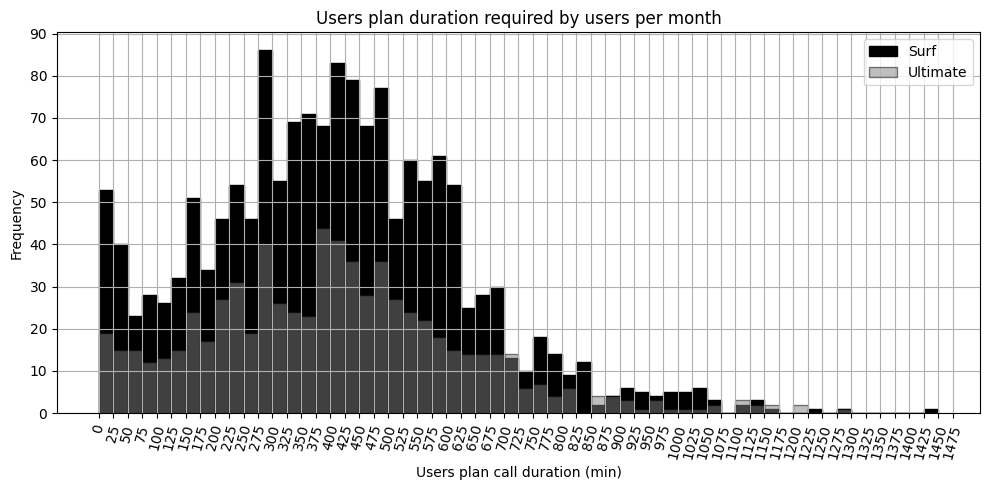

In [140]:
bins = np.arange(0, 1475, 25)

plt.figure(figsize=(10, 5))

plt.hist(surf_duration, bins=bins, edgecolor='black', color='black', label='Surf')
plt.hist(ultimate_duration, bins=bins, edgecolor='black', alpha=0.5, color='grey', label='Ultimate')
plt.title('Users plan duration required by users per month')
plt.xlabel('Users plan call duration (min)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(0, 1480, 25), rotation=75)
plt.yticks(range(0, 100, 10), rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

[Calculate the mean and variable call duration to find out if users on different plans behave differently when making calls.]

In [141]:
# Calculate the mean and variance of monthly call durations.

mean_duration = df_user_activity_per_month['duration_month'].mean()
var_duration = df_user_activity_per_month['duration_month'].var()
std_duration = df_user_activity_per_month['duration_month'].std()

print("> Average monthly call duration:", mean_duration)
print("> Variance of call duration:", var_duration)
print("> Standard deviation of call duration:", std_duration)

> Average monthly call duration: 405.2116266899258
> Variance of call duration: 49900.198221567385
> Standard deviation of call duration: 223.3835227172483


In [ ]:
# Draw a box plot to visualize the distribution of monthly call duration

[Draw conclusions about user call behavior. Does their behavior vary by plan?]

`LSPL`   
>The monthly call duration analysis shows outliers above 986 minutes (calculated with Q3 + 1.5 * IQR), so the outliers exceeding the upper limit (977,430 and above) represent 20 of the 500 users. Reviewing their profiles, no patterns related to plan or city were detected, although the majority are over 30 years old. A slight trend was identified in the New York and New Jersey area, which could suggest greater usage due to work activities and location in the city.

>The Surf plan has an average monthly usage of 401.76 minutes compared to 398.585 minutes for the Ultimate plan. Although the Ultimate plan offers more minutes per call, users tend to consume less, which could be due to demographic differences or usage patterns and especially considering that for the sample size of the data available, there are a greater number of users in the "Surf" plan (339) than in the "Ultimeate" plan (161).

### 1.14.2. Messages

In [143]:
print(df_user_activity_per_month['messages_count'].describe())

count    2293.000000
mean       33.166594
std        34.070085
min         0.000000
25%         3.000000
50%        26.000000
75%        51.000000
max       266.000000
Name: messages_count, dtype: float64


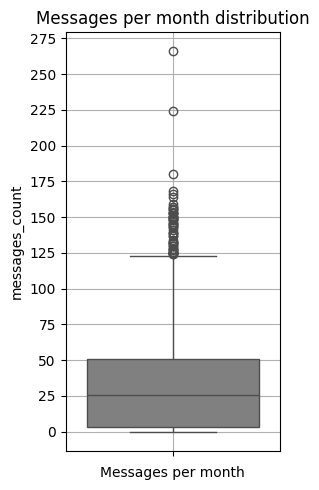

In [144]:
plt.figure(figsize=(3, 5))
sns.boxplot(y='messages_count', data=df_user_activity_per_month, color='grey')

plt.xlabel('Messages per month')
plt.title('Messages per month distribution')
plt.grid(True)
plt.yticks(range(0, 300, 25), rotation=0)

plt.tight_layout()
plt.show()

In [145]:
df_messages_outliers = outlier_limit_bounds(df_user_activity_per_month, 'messages_count', bound='upper')

> Upper bound of outliers for column 'messages_count': 123.0


In [146]:
outliers_messages_user_id = df_messages_outliers['user_id'].unique()

print(f"> Users identified as outliers for column 'messages_count':\n\n{outliers_messages_user_id}")

> Users identified as outliers for column 'messages_count':

[1006 1019 1052 1057 1076 1119 1132 1229 1230 1267 1301 1303 1324 1328
 1343 1379 1381 1419 1433 1435 1470]


In [147]:
df_ol_m_users = df_users.loc[(df_users['user_id']).isin(outliers_messages_user_id), :]

`LSPL`   
> Descriptive statistics for users identified as outliers.

In [150]:
print(df_ol_m_users[['user_id', 'age']].describe())

           user_id        age
count    21.000000  21.000000
mean   1252.523810  43.523810
std     150.964108  16.797676
min    1006.000000  18.000000
25%    1119.000000  34.000000
50%    1301.000000  44.000000
75%    1379.000000  53.000000
max    1470.000000  73.000000


In [149]:
print(df_ol_m_users.describe(include=['object']))

                                         city  plan        full_name
count                                      21    21               21
unique                                     17     2               21
top     san_francisco-oakland-berkeley_ca_msa  surf  jesusa_bradford
freq                                        2    12                1


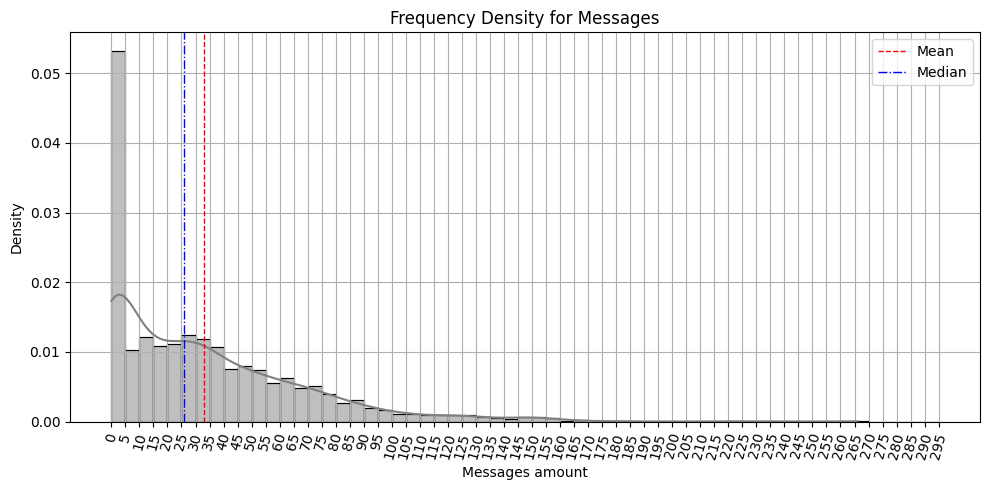

In [151]:
messages = df_user_activity_per_month['messages_count'].dropna()
mean = messages.mean()
median = messages.median()

bins = np.arange(0, 300, 5)

plt.figure(figsize=(10, 5))

sns.histplot(messages, bins=bins, kde=True, stat="density", color='grey')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='blue', linestyle='-.', linewidth=1, label='Median')
plt.title('Frequency Density for Messages')
plt.xlabel('Messages amount')
plt.ylabel('Density')
plt.grid(True)
plt.xticks(range(0, 300, 5), rotation=75)
plt.legend()

plt.tight_layout()
plt.show()

In [152]:
# Compare the average number of messages sent per plan and per month. Plot a bar chart to visualize it.

df_median_messages_per_plan_month = df_user_activity_per_month.pivot_table(index='plan', columns='month',
                                                                           values='messages_count', aggfunc='median')
print(df_median_messages_per_plan_month)

month     2018-01  2018-02  2018-03  2018-04  2018-05  2018-06  2018-07  2018-08  2018-09  2018-10  2018-11  2018-12
plan                                                                                                                
surf         10.5      3.0      7.0     10.0     15.0     15.0     20.0     20.0     22.5     26.0     27.0     31.0
ultimate     12.5     15.0     12.0     17.0     19.0     21.0     28.0     36.0     31.5     35.0     32.0     41.0


In [153]:
df_median_messages_per_plan_month = df_median_messages_per_plan_month.reset_index().melt(
    id_vars='plan',
    var_name='month',
    value_name='median_messages'
)

print(df_median_messages_per_plan_month)

        plan    month  median_messages
0       surf  2018-01             10.5
1   ultimate  2018-01             12.5
2       surf  2018-02              3.0
3   ultimate  2018-02             15.0
4       surf  2018-03              7.0
5   ultimate  2018-03             12.0
6       surf  2018-04             10.0
7   ultimate  2018-04             17.0
8       surf  2018-05             15.0
9   ultimate  2018-05             19.0
10      surf  2018-06             15.0
11  ultimate  2018-06             21.0
12      surf  2018-07             20.0
13  ultimate  2018-07             28.0
14      surf  2018-08             20.0
15  ultimate  2018-08             36.0
16      surf  2018-09             22.5
17  ultimate  2018-09             31.5
18      surf  2018-10             26.0
19  ultimate  2018-10             35.0
20      surf  2018-11             27.0
21  ultimate  2018-11             32.0
22      surf  2018-12             31.0
23  ultimate  2018-12             41.0


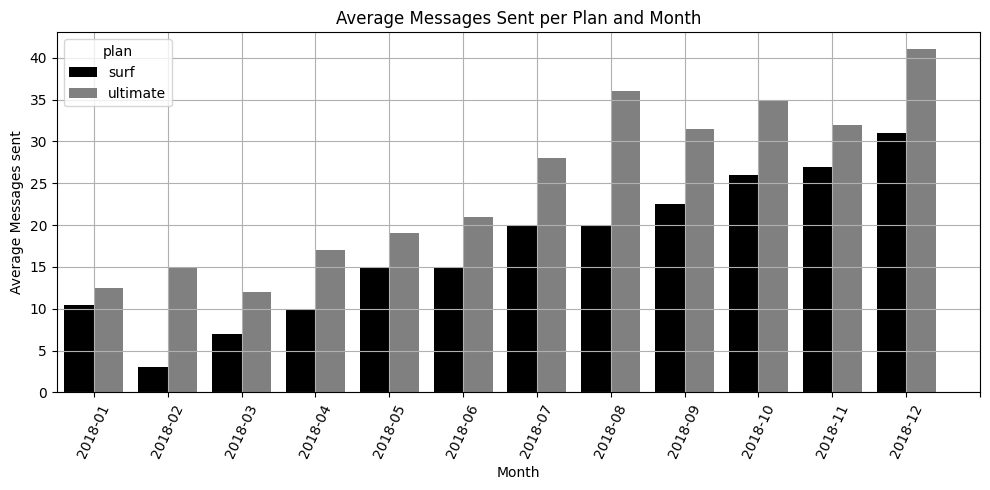

In [154]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_median_messages_per_plan_month, x='month', y='median_messages', hue='plan', palette=['black', 'grey'])

plt.xlabel('Month')
plt.ylabel('Average Messages sent')
plt.title('Average Messages Sent per Plan and Month')
plt.grid(True)
plt.xticks(range(0, 13, 1), rotation=65)
plt.yticks(range(0, 45, 5))

plt.tight_layout()
plt.show()

In [155]:
median_messages_surf = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'surf'), 'messages_count'].median()
median_messages_ultimate = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'ultimate'), 'messages_count'].median()

print(f"> Average messages sent for plan (Surf): {median_messages_surf:.2f}")
print(f"> Average messages sent for plan (Ultimate): {median_messages_ultimate:.2f}")

> Average messages sent for plan (Surf): 24.00
> Average messages sent for plan (Ultimate): 30.00


In [156]:
# Compare the number of messages that users on each plan tend to send each month

surf_messages = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'surf'), 'messages_count']
ultimate_messages = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'ultimate'), 'messages_count']

print(surf_messages)
print()
print(ultimate_messages)

1       30.0
2       44.0
3       53.0
4       36.0
5       44.0
        ... 
2282    56.0
2286    76.0
2287    72.0
2288    61.0
2289     2.0
Name: messages_count, Length: 1573, dtype: float64

0        11.0
19       15.0
20      139.0
26       21.0
27       37.0
        ...  
2284     78.0
2285      5.0
2290      2.0
2291      0.0
2292      0.0
Name: messages_count, Length: 720, dtype: float64


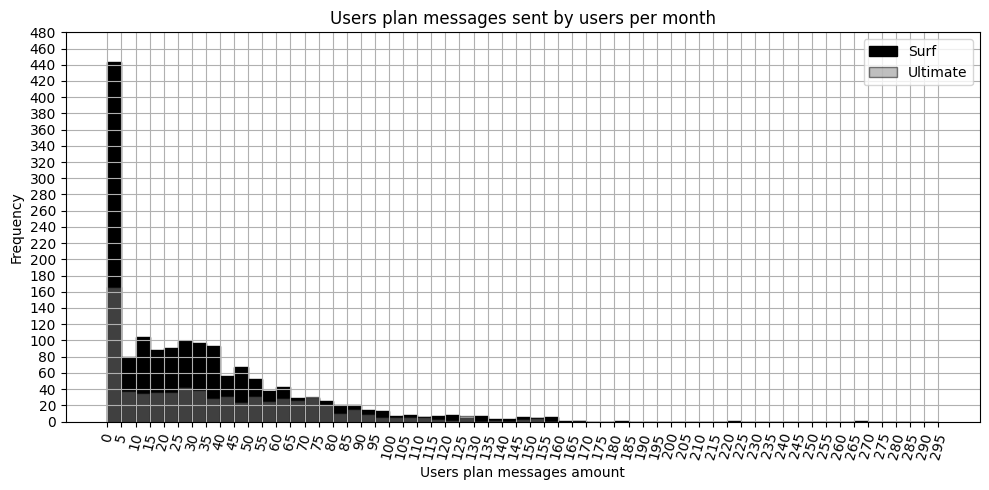

In [157]:
bins = np.arange(0, 300, 5)

plt.figure(figsize=(10, 5))

plt.hist(surf_messages, bins=bins, edgecolor='black', color='black', label='Surf')
plt.hist(ultimate_messages, bins=bins, edgecolor='black', alpha=0.5, color='grey', label='Ultimate')
plt.title('Users plan messages sent by users per month')
plt.xlabel('Users plan messages amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(0, 300, 5), rotation=75)
plt.yticks(range(0, 500, 20), rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

[Calculate the mean and variable of the number of messages sent to find out if users on different plans behave differently when sending messages]

In [158]:
mean_messages = df_user_activity_per_month['messages_count'].mean()
var_messages = df_user_activity_per_month['messages_count'].var()
std_messages = df_user_activity_per_month['messages_count'].std()

print("> Monthly average messages sent:", mean_messages)
print("> Messages variance:", var_messages)
print("> Standard deviation of messages:", std_messages)

> Monthly average messages sent: 33.166593981683384
> Messages variance: 1160.770663655758
> Standard deviation of messages: 34.07008458539189


[Draw conclusions about user messaging behavior. Does their behavior vary depending on the plan?]

`LSPL`   
> The analysis of monthly messaging shows outliers above 123 messages (calculated with Q3 + 1.5 * IQR). These represent 21 of 500 users. Reviewing their profiles, no strong patterns related to plan or city are detected, although the majority are over 34 years old, which could suggest greater usage due to work-related activities.

> The Surf plan has an average monthly usage of 24 messages compared to 30 messages for the Ultimate plan. The Ultimate plan offers more messages; users tend to consume more messages with the Ultimate plan, which could be due to demographic differences or usage patterns. It should be noted that, for the sample size of the data available, there are more users on the "Surf" plan (339) than on the "Ultimate" plan (161).

### 1.14.3. Internet

In [159]:
print(df_user_activity_per_month['traffic_count'].describe())

count     2293.000000
mean     16764.397606
std       7967.237527
min          0.000000
25%      12235.760000
50%      16830.640000
75%      20999.840000
max      70931.590000
Name: traffic_count, dtype: float64


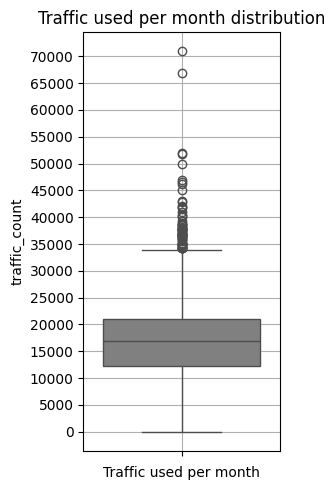

In [160]:
plt.figure(figsize=(3, 5))
sns.boxplot(y='traffic_count', data=df_user_activity_per_month, color='grey')

plt.xlabel('Traffic used per month')
plt.title('Traffic used per month distribution')
plt.grid(True)
plt.yticks(range(0, 75000, 5000), rotation=0)

plt.tight_layout()
plt.show()

In [161]:
df_traffic_outliers = outlier_limit_bounds(df_user_activity_per_month, 'traffic_count', bound='upper')

> Upper bound of outliers for column 'traffic_count': 34145.96


In [185]:
outliers_traffic_user_id = df_traffic_outliers['user_id'].unique()

print(f"> Users identified as outliers for column 'traffic_count':\n\n{outliers_traffic_user_id}")

> Users identified as outliers for column 'traffic_count':

[1007 1028 1038 1043 1057 1072 1126 1144 1147 1172 1201 1215 1240 1251
 1267 1268 1272 1292 1293 1301 1328 1359 1369 1373 1374 1379 1403 1416
 1418 1447 1460 1490 1121 1194 1204]


In [163]:
df_ol_i_users = df_users.loc[(df_users['user_id']).isin(outliers_traffic_user_id), :]

In [165]:
print(df_ol_i_users[['user_id', 'age']].describe())

           user_id        age
count    35.000000  35.000000
mean   1250.542857  45.714286
std     137.226164  17.009636
min    1007.000000  18.000000
25%    1145.500000  33.000000
50%    1267.000000  42.000000
75%    1371.000000  61.500000
max    1490.000000  72.000000


In [166]:
print(df_ol_i_users.describe(include=['object']))

                                            city  plan      full_name
count                                         35    35             35
unique                                        22     2             35
top     new_york-newark-jersey_city_ny-nj-pa_msa  surf  eusebio_welch
freq                                           5    23              1


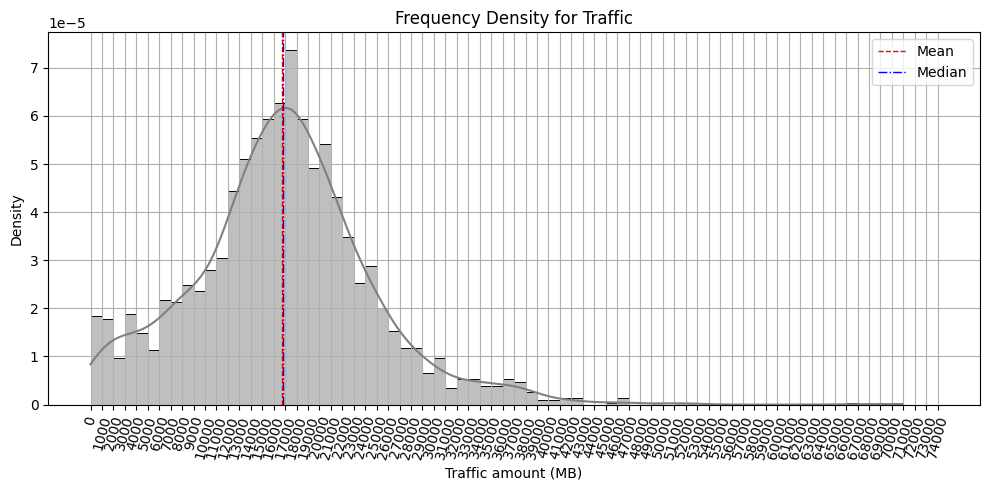

In [167]:
traffic = df_user_activity_per_month['traffic_count'].dropna()
mean = traffic.mean()
median = traffic.median()

bins = np.arange(0, 75000, 1000)

plt.figure(figsize=(10, 5))

sns.histplot(traffic, bins=bins, kde=True, stat="density", color='grey')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='blue', linestyle='-.', linewidth=1, label='Median')
plt.title('Frequency Density for Traffic')
plt.xlabel('Traffic amount (MB)')
plt.ylabel('Density')
plt.grid(True)
plt.xticks(range(0, 75000, 1000), rotation=75)
plt.legend()

plt.tight_layout()
plt.show()

In [168]:
# Compare the average amount of traffic used by each plan and by month. Plot a bar chart to visualize it.

df_median_traffic_per_plan_month = df_user_activity_per_month.pivot_table(index='plan', columns='month',
values='traffic_count', aggfunc='median')
print(df_median_traffic_per_plan_month)

month     2018-01   2018-02    2018-03   2018-04   2018-05   2018-06   2018-07   2018-08    2018-09   2018-10   2018-11    2018-12
plan                                                                                                                              
surf      4874.86  11828.25  13867.940  11814.10  13953.25  15479.97  16876.57  16879.51  16968.935  17460.79  16813.83  17722.115
ultimate  7860.69  20085.20  20812.505  15651.16  16499.79  15342.76  15068.78  17954.65  16434.410  16969.91  17130.90  17346.080


In [169]:
df_median_traffic_per_plan_month = df_median_traffic_per_plan_month.reset_index().melt(
    id_vars='plan',
    var_name='month',
    value_name='median_traffic'
)

print(df_median_traffic_per_plan_month)

        plan    month  median_traffic
0       surf  2018-01        4874.860
1   ultimate  2018-01        7860.690
2       surf  2018-02       11828.250
3   ultimate  2018-02       20085.200
4       surf  2018-03       13867.940
5   ultimate  2018-03       20812.505
6       surf  2018-04       11814.100
7   ultimate  2018-04       15651.160
8       surf  2018-05       13953.250
9   ultimate  2018-05       16499.790
10      surf  2018-06       15479.970
11  ultimate  2018-06       15342.760
12      surf  2018-07       16876.570
13  ultimate  2018-07       15068.780
14      surf  2018-08       16879.510
15  ultimate  2018-08       17954.650
16      surf  2018-09       16968.935
17  ultimate  2018-09       16434.410
18      surf  2018-10       17460.790
19  ultimate  2018-10       16969.910
20      surf  2018-11       16813.830
21  ultimate  2018-11       17130.900
22      surf  2018-12       17722.115
23  ultimate  2018-12       17346.080


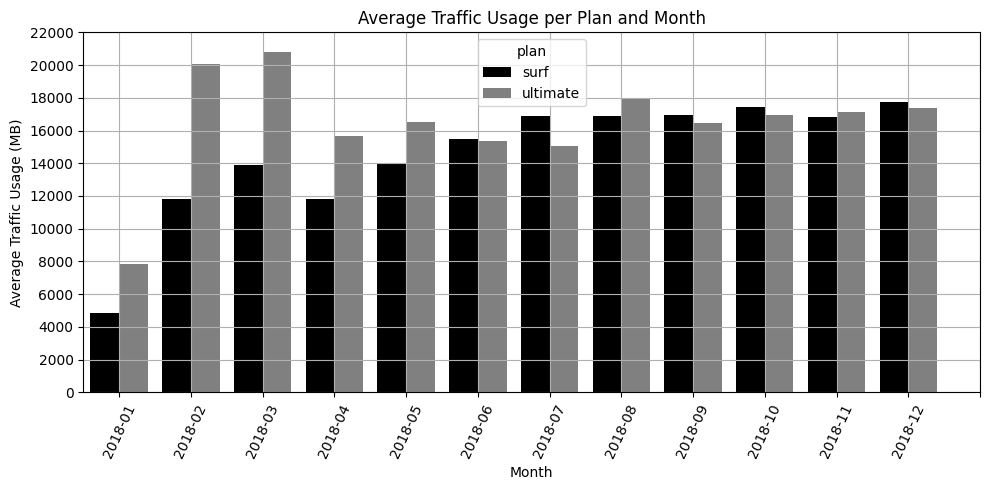

In [170]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_median_traffic_per_plan_month, x='month', y='median_traffic', hue='plan', palette=['black', 'grey'])

plt.xlabel('Month')
plt.ylabel('Average Traffic Usage (MB)')
plt.title('Average Traffic Usage per Plan and Month')
plt.grid(True)
plt.xticks(range(0, 13, 1), rotation=65)
plt.yticks(range(0, 23000, 2000))

plt.tight_layout()
plt.show()

In [171]:
median_traffic_surf = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'surf'), 'traffic_count'].median()
median_traffic_ultimate = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'ultimate'), 'traffic_count'].median()

print(f"> Average traffic consumed for plan (Surf): {median_traffic_surf:.2f}")
print(f"> Average traffic consumed for plan (Ultimate): {median_traffic_ultimate:.2f}")

> Average traffic consumed for plan (Surf): 16829.31
> Average traffic consumed for plan (Ultimate): 16858.34


In [172]:
# Compare the amount of traffic that users of each plan tend to use each month

surf_traffic = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'surf'), 'traffic_count']
ultimate_traffic = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'ultimate'), 'traffic_count']

print(surf_traffic)
print()
print(ultimate_traffic)

1        6919.15
2       13314.82
3       22330.49
4       18504.30
5       19369.18
          ...   
2282    31088.49
2286    13093.55
2287    17128.26
2288    13039.91
2289     1519.69
Name: traffic_count, Length: 1573, dtype: float64

0        1901.47
19       2068.37
20      32118.82
26      17106.99
27      23676.72
          ...   
2284    36730.05
2285     2966.21
2290        0.00
2291      233.17
2292     1498.83
Name: traffic_count, Length: 720, dtype: float64


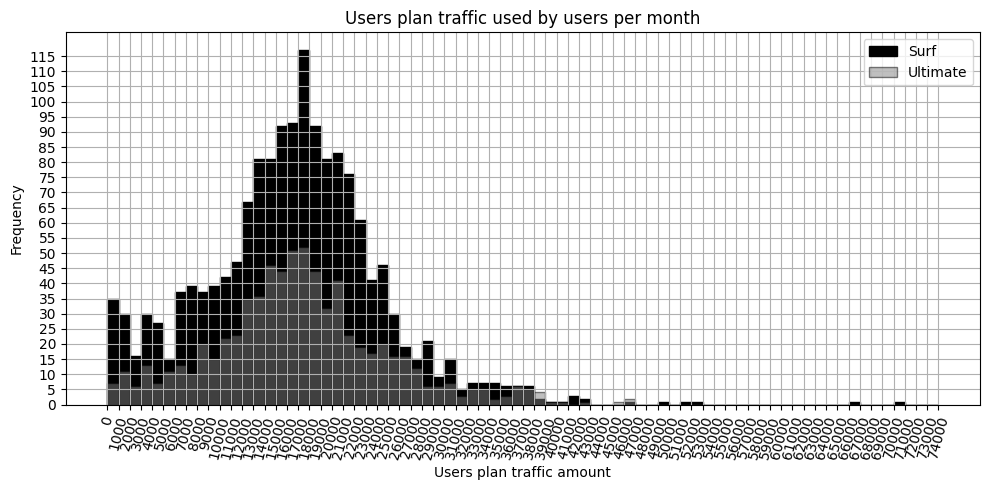

In [173]:
bins = np.arange(0, 75000, 1000)

plt.figure(figsize=(10, 5))

plt.hist(surf_traffic, bins=bins, edgecolor='black', color='black', label='Surf')
plt.hist(ultimate_traffic, bins=bins, edgecolor='black', alpha=0.5, color='grey', label='Ultimate')
plt.title('Users plan traffic used by users per month')
plt.xlabel('Users plan traffic amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(0, 75000, 1000), rotation=75)
plt.yticks(range(0, 120, 5), rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

[Draw conclusions about how users tend to consume Internet traffic. Does their behavior vary depending on the plan?]

`LSPL`   
> The monthly traffic consumption analysis shows outliers above 34,145.96 MB (calculated with Q3 + 1.5 * IQR). These represent 35 out of 500 users. Reviewing their profiles reveals no strong patterns related to plan or city, although the majority are over 33 years old, and a slight trend was identified in the New York and New Jersey areas, which could suggest higher usage due to work activities and city location.

> The Surf plan shows an average monthly consumption of 16,829 GB compared to 16,858 GB for the Ultimate plan. Although the Ultimate plan offers more data, users tend to consume approximately the same amount of data, which could be due to demographic differences or usage patterns and especially considering that for the sample size of the data available, there are a greater number of users on the "Surf" plan (339) than on the "Ultimeate" plan (161).

### 1.15. Revenue
[Just as you have studied user behavior, describe the revenue of the plans statistically.]

In [174]:
print(df_user_activity_per_month.sample(25, random_state=333))

      user_id    month  calls_count  duration_month  messages_count  traffic_count      plan  monthly_income
2084     1460  2018-07         50.0          381.65            44.0       29541.12  ultimate        70.00000
262      1060  2018-09         92.0          624.89            66.0       26256.75      surf       133.19420
1266     1276  2018-11         54.0          408.76            19.0       10918.63      surf        20.00000
695      1150  2018-12         76.0          455.45             0.0       12881.10  ultimate        70.00000
833      1179  2018-07         21.0          172.94             4.0        1473.95      surf        20.00000
1732     1382  2018-07        163.0         1029.27            52.0       13018.42  ultimate        70.00000
1806     1397  2018-07        121.0          898.44             0.0       24072.19      surf       119.07510
682      1147  2018-09         89.0          532.19            18.0       35929.97      surf       226.66540
171      1043  2018

In [175]:
df_user_activity_per_month = df_user_activity_per_month.rename(columns={"monthly_income": "services_income"})

In [176]:
print(df_user_activity_per_month.sample(25, random_state=333))

      user_id    month  calls_count  duration_month  messages_count  traffic_count      plan  services_income
2084     1460  2018-07         50.0          381.65            44.0       29541.12  ultimate         70.00000
262      1060  2018-09         92.0          624.89            66.0       26256.75      surf        133.19420
1266     1276  2018-11         54.0          408.76            19.0       10918.63      surf         20.00000
695      1150  2018-12         76.0          455.45             0.0       12881.10  ultimate         70.00000
833      1179  2018-07         21.0          172.94             4.0        1473.95      surf         20.00000
1732     1382  2018-07        163.0         1029.27            52.0       13018.42  ultimate         70.00000
1806     1397  2018-07        121.0          898.44             0.0       24072.19      surf        119.07510
682      1147  2018-09         89.0          532.19            18.0       35929.97      surf        226.66540
171      1

In [177]:
df_user_activity_per_month['calls_income'] = df_user_activity_per_month.apply(lambda row: income(row, income_type='duration'), axis=1)
df_user_activity_per_month['messages_income'] = df_user_activity_per_month.apply(lambda row: income(row, income_type='messages'), axis=1)
df_user_activity_per_month['traffic_income'] = df_user_activity_per_month.apply(lambda row: income(row, income_type='traffic'), axis=1)

In [178]:
print(df_user_activity_per_month.sample(25, random_state=333))

      user_id    month  calls_count  duration_month  messages_count  traffic_count      plan  services_income  calls_income  messages_income  \
2084     1460  2018-07         50.0          381.65            44.0       29541.12  ultimate         70.00000       70.0000            70.00   
262      1060  2018-09         92.0          624.89            66.0       26256.75      surf        133.19420       23.7467            20.48   
1266     1276  2018-11         54.0          408.76            19.0       10918.63      surf         20.00000       20.0000            20.00   
695      1150  2018-12         76.0          455.45             0.0       12881.10  ultimate         70.00000       70.0000            70.00   
833      1179  2018-07         21.0          172.94             4.0        1473.95      surf         20.00000       20.0000            20.00   
1732     1382  2018-07        163.0         1029.27            52.0       13018.42  ultimate         70.00000       70.0000            7

In [179]:
df_user_activity_per_month = df_user_activity_per_month.merge(df_users[['user_id', 'city']], on='user_id', how='left')

In [180]:
print(df_user_activity_per_month.sample(25, random_state=333))

      user_id    month  calls_count  duration_month  messages_count  traffic_count      plan  services_income  calls_income  messages_income  \
2084     1460  2018-07         50.0          381.65            44.0       29541.12  ultimate         70.00000       70.0000            70.00   
262      1060  2018-09         92.0          624.89            66.0       26256.75      surf        133.19420       23.7467            20.48   
1266     1276  2018-11         54.0          408.76            19.0       10918.63      surf         20.00000       20.0000            20.00   
695      1150  2018-12         76.0          455.45             0.0       12881.10  ultimate         70.00000       70.0000            70.00   
833      1179  2018-07         21.0          172.94             4.0        1473.95      surf         20.00000       20.0000            20.00   
1732     1382  2018-07        163.0         1029.27            52.0       13018.42  ultimate         70.00000       70.0000            7

In [181]:
print(df_user_activity_per_month[["services_income", "calls_income", "messages_income", "traffic_income"]].describe())

       services_income  calls_income  messages_income  traffic_income
count      2293.000000   2293.000000      2293.000000     2293.000000
mean         62.550346     36.704747        35.844278       61.401233
std          46.427396     22.696270        23.118262       45.888898
min          20.000000     20.000000        20.000000       20.000000
25%          22.163900     20.000000        20.000000       20.000000
50%          70.000000     20.915600        20.000000       70.000000
75%          70.000000     70.000000        70.000000       70.000000
max         594.353100     70.000000        70.000000      575.715900


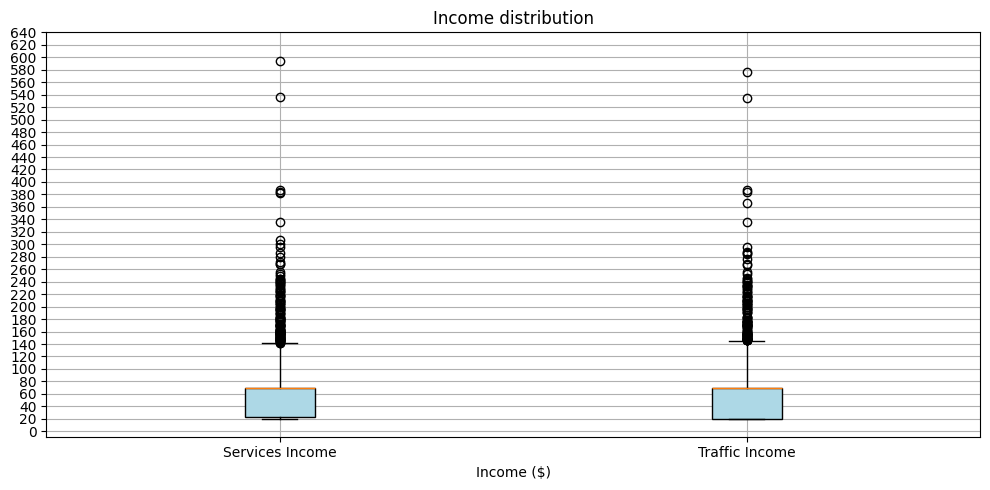

In [182]:
plt.figure(figsize=(10, 5))
plt.boxplot([df_user_activity_per_month['services_income'], 
             df_user_activity_per_month["traffic_income"]],
			vert=True, 
   			patch_artist=True, 
      		boxprops=dict(facecolor='lightblue'))

plt.xlabel('Income ($)')
plt.title('Income distribution')
plt.grid(True)
plt.xticks([1, 2], ['Services Income', 'Traffic Income'])
plt.yticks(range(0, 650, 20), rotation=0)

plt.tight_layout()
plt.show()

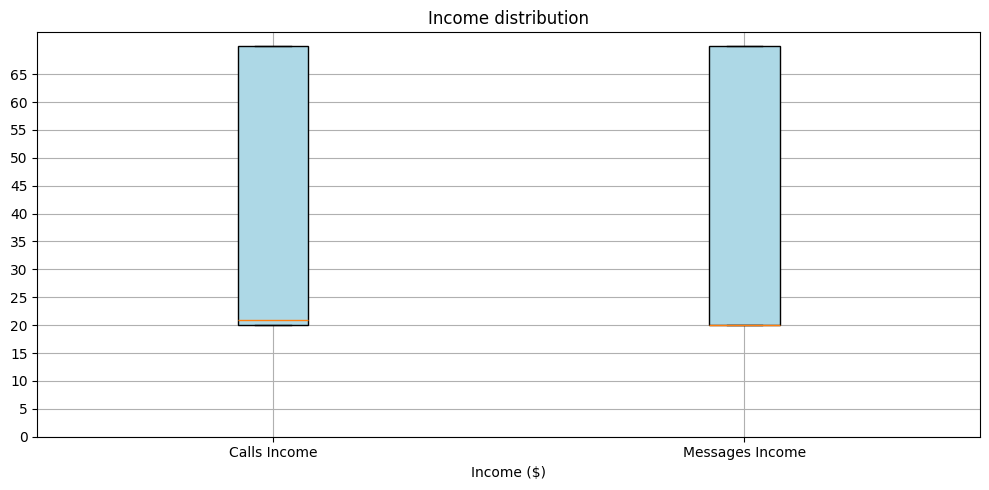

In [183]:
plt.figure(figsize=(10, 5))
plt.boxplot([df_user_activity_per_month['calls_income'],
             df_user_activity_per_month["messages_income"]], 
			vert=True, 
   			patch_artist=True, 
      		boxprops=dict(facecolor='lightblue'))

plt.xlabel('Income ($)')
plt.title('Income distribution')
plt.grid(True)
plt.xticks([1, 2], ['Calls Income', 'Messages Income'])
plt.yticks(range(0, 70, 5), rotation=0)

plt.tight_layout()
plt.show()

### 1.15.0.1. Calls Revenue

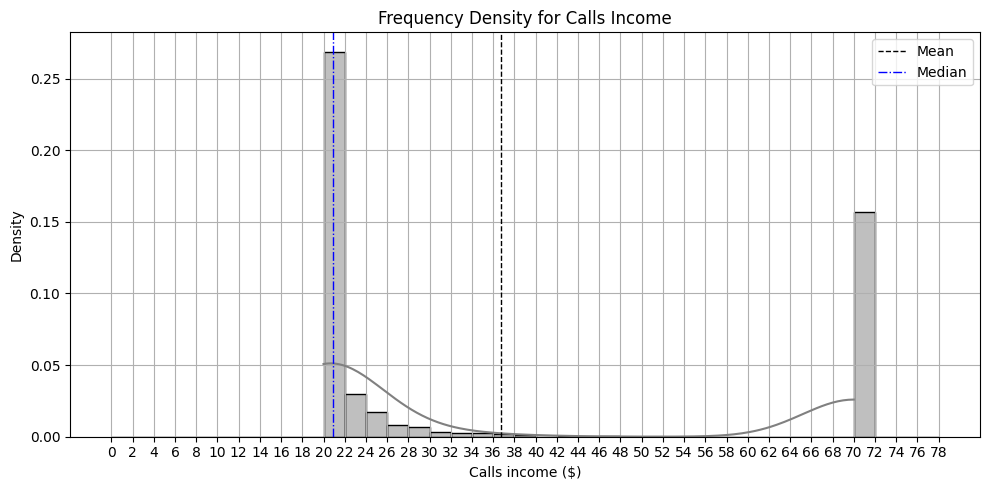

In [198]:
calls = df_user_activity_per_month['calls_income'].dropna()
mean = calls.mean()
median = calls.median()

bins = np.arange(0, 80, 2)

plt.figure(figsize=(10, 5))

sns.histplot(calls, bins=bins, kde=True, stat="density", color='grey')
plt.axvline(mean, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='blue', linestyle='-.', linewidth=1, label='Median')
plt.title('Frequency Density for Calls Income')
plt.xlabel('Calls income ($)')
plt.ylabel('Density')
plt.grid(True)
plt.xticks(range(0, 80, 2), rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

In [199]:
# Compare the average call revenue for each plan and each month. Plot a bar chart to visualize it.

df_median_income_calls_per_plan_month = df_user_activity_per_month.pivot_table(index='plan', columns='month',
values='calls_income', aggfunc='median')
print(df_median_income_calls_per_plan_month)

month     2018-01  2018-02  2018-03  2018-04  2018-05  2018-06  2018-07  2018-08  2018-09  2018-10  2018-11  2018-12
plan                                                                                                                
surf         20.0     20.0     20.0     20.0     20.0     20.0     20.0     20.0     20.0     20.0     20.0     20.0
ultimate     70.0     70.0     70.0     70.0     70.0     70.0     70.0     70.0     70.0     70.0     70.0     70.0


In [200]:
df_median_income_calls_per_plan_month = df_median_income_calls_per_plan_month.reset_index().melt(
    id_vars='plan',
    var_name='month',
    value_name='median_calls_income'
)

print(df_median_income_calls_per_plan_month)

        plan    month  median_calls_income
0       surf  2018-01                 20.0
1   ultimate  2018-01                 70.0
2       surf  2018-02                 20.0
3   ultimate  2018-02                 70.0
4       surf  2018-03                 20.0
5   ultimate  2018-03                 70.0
6       surf  2018-04                 20.0
7   ultimate  2018-04                 70.0
8       surf  2018-05                 20.0
9   ultimate  2018-05                 70.0
10      surf  2018-06                 20.0
11  ultimate  2018-06                 70.0
12      surf  2018-07                 20.0
13  ultimate  2018-07                 70.0
14      surf  2018-08                 20.0
15  ultimate  2018-08                 70.0
16      surf  2018-09                 20.0
17  ultimate  2018-09                 70.0
18      surf  2018-10                 20.0
19  ultimate  2018-10                 70.0
20      surf  2018-11                 20.0
21  ultimate  2018-11                 70.0
22      sur

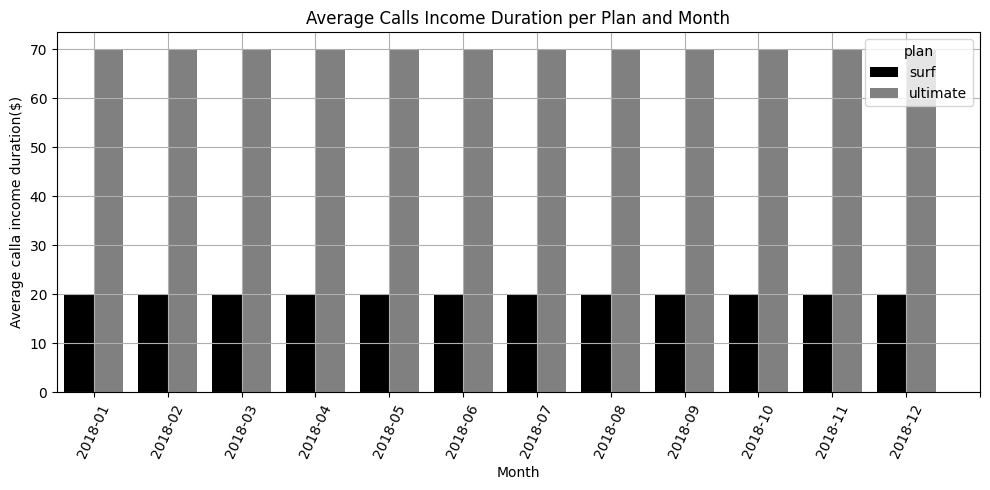

In [201]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_median_income_calls_per_plan_month, x='month', y='median_calls_income', hue='plan', palette=['black', 'grey'])

plt.xlabel('Month')
plt.ylabel('Average calla income duration($)')
plt.title('Average Calls Income Duration per Plan and Month')
plt.grid(True)
plt.xticks(range(0, 13, 1), rotation=65)
plt.yticks(range(0, 75, 10))

plt.tight_layout()
plt.show()

In [202]:
surf_calls_income = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'surf'), 'calls_income']
ultimate_calls_income = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'ultimate'), 'calls_income']

print(surf_calls_income)
print()
print(ultimate_calls_income)

1       20.0
2       20.0
3       20.0
4       20.0
5       20.0
        ... 
2282    20.0
2286    20.0
2287    20.0
2288    20.0
2289    20.0
Name: calls_income, Length: 1573, dtype: float64

0       70.0
19      70.0
20      70.0
26      70.0
27      70.0
        ... 
2284    70.0
2285    70.0
2290    70.0
2291    70.0
2292    70.0
Name: calls_income, Length: 720, dtype: float64


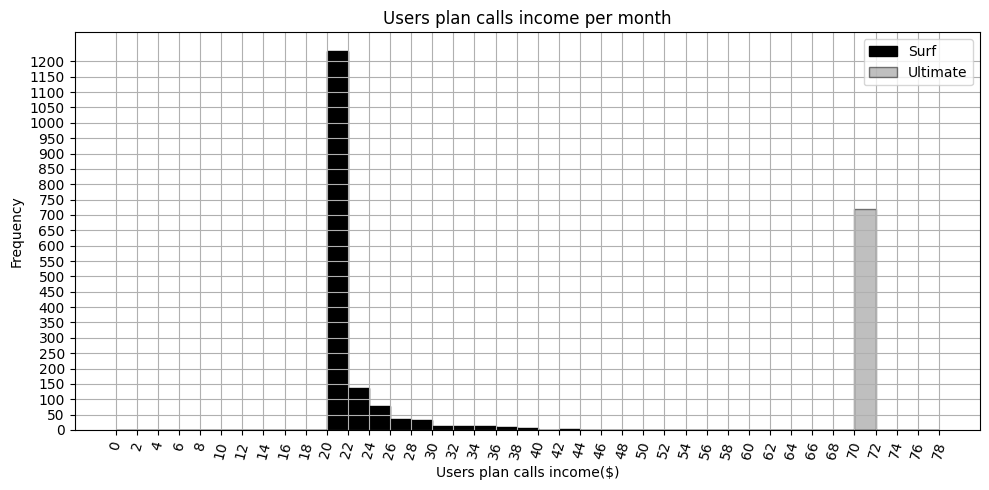

In [203]:
bins = np.arange(0, 80, 2)

plt.figure(figsize=(10, 5))

plt.hist(surf_calls_income, bins=bins, edgecolor='black', color='black', label='Surf')
plt.hist(ultimate_calls_income, bins=bins, edgecolor='black', alpha=0.5, color='grey', label='Ultimate')
plt.title('Users plan calls income per month')
plt.xlabel('Users plan calls income($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(0, 80, 2), rotation=75)
plt.yticks(range(0, 1250, 50), rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

### 1.15.0.2. Messages Revenue

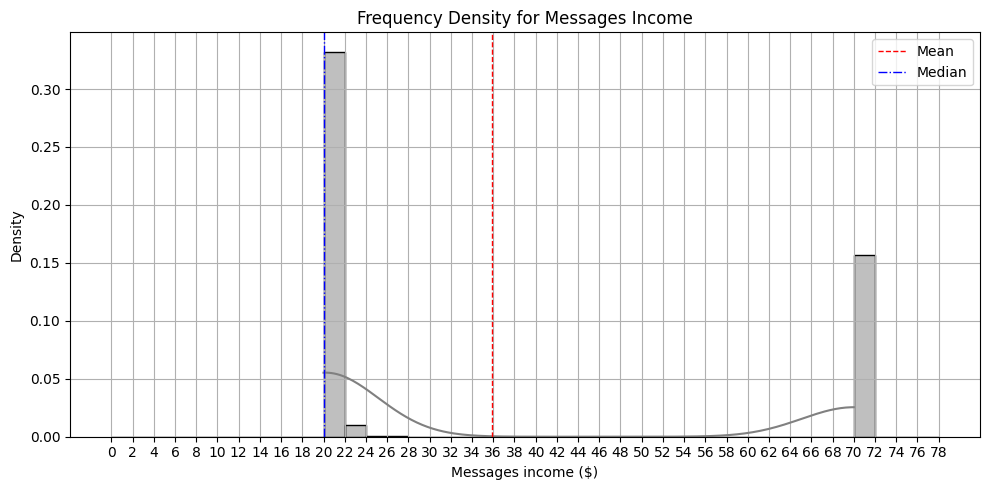

In [192]:
messages = df_user_activity_per_month['messages_income'].dropna()
mean = messages.mean()
median = messages.median()

bins = np.arange(0, 80, 2)

plt.figure(figsize=(10, 5))

sns.histplot(messages, bins=bins, kde=True, stat="density", color='grey')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='blue', linestyle='-.', linewidth=1, label='Median')
plt.title('Frequency Density for Messages Income')
plt.xlabel('Messages income ($)')
plt.ylabel('Density')
plt.grid(True)
plt.xticks(range(0, 80, 2), rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

In [193]:
# Compare the average message income for each plan and each month. Plot a bar chart to visualize it.

df_median_income_messages_per_plan_month = df_user_activity_per_month.pivot_table(index='plan', columns='month',
values='messages_income', aggfunc='median')
print(df_median_income_messages_per_plan_month)

month     2018-01  2018-02  2018-03  2018-04  2018-05  2018-06  2018-07  2018-08  2018-09  2018-10  2018-11  2018-12
plan                                                                                                                
surf         20.0     20.0     20.0     20.0     20.0     20.0     20.0     20.0     20.0     20.0     20.0     20.0
ultimate     70.0     70.0     70.0     70.0     70.0     70.0     70.0     70.0     70.0     70.0     70.0     70.0


In [194]:
df_median_income_messages_per_plan_month = df_median_income_messages_per_plan_month.reset_index().melt(
    id_vars='plan',
    var_name='month',
    value_name='median_messages_income'
)

print(df_median_income_messages_per_plan_month)

        plan    month  median_messages_income
0       surf  2018-01                    20.0
1   ultimate  2018-01                    70.0
2       surf  2018-02                    20.0
3   ultimate  2018-02                    70.0
4       surf  2018-03                    20.0
5   ultimate  2018-03                    70.0
6       surf  2018-04                    20.0
7   ultimate  2018-04                    70.0
8       surf  2018-05                    20.0
9   ultimate  2018-05                    70.0
10      surf  2018-06                    20.0
11  ultimate  2018-06                    70.0
12      surf  2018-07                    20.0
13  ultimate  2018-07                    70.0
14      surf  2018-08                    20.0
15  ultimate  2018-08                    70.0
16      surf  2018-09                    20.0
17  ultimate  2018-09                    70.0
18      surf  2018-10                    20.0
19  ultimate  2018-10                    70.0
20      surf  2018-11             

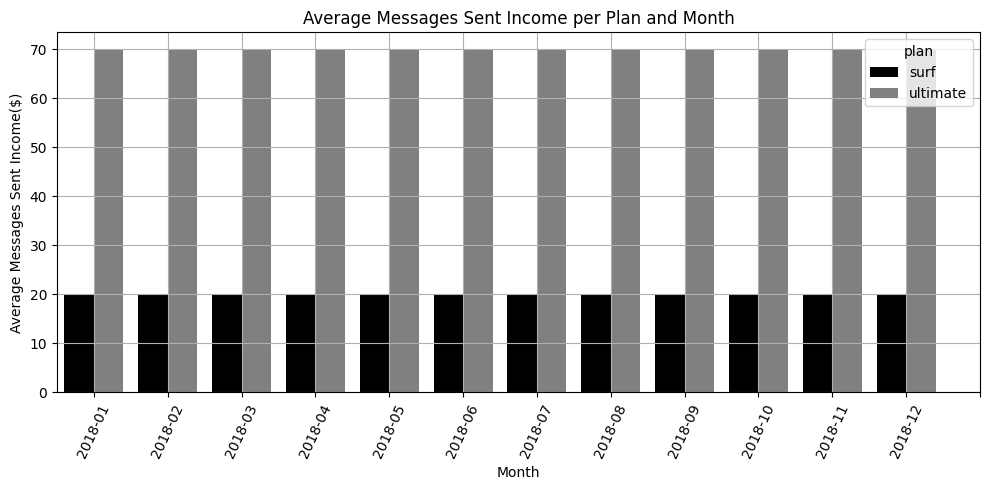

In [195]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_median_income_messages_per_plan_month, x='month', y='median_messages_income', hue='plan', palette=['black', 'grey'])

plt.xlabel('Month')
plt.ylabel('Average Messages Sent Income($)')
plt.title('Average Messages Sent Income per Plan and Month')
plt.grid(True)
plt.xticks(range(0, 13, 1), rotation=65)
plt.yticks(range(0, 75, 10))

plt.tight_layout()
plt.show()

In [196]:
surf_messages_income = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'surf'), 'messages_income']
ultimate_messages_income = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'ultimate'), 'messages_income']

print(surf_messages_income)
print()
print(ultimate_messages_income)

1       20.00
2       20.00
3       20.09
4       20.00
5       20.00
        ...  
2282    20.18
2286    20.78
2287    20.66
2288    20.33
2289    20.00
Name: messages_income, Length: 1573, dtype: float64

0       70.0
19      70.0
20      70.0
26      70.0
27      70.0
        ... 
2284    70.0
2285    70.0
2290    70.0
2291    70.0
2292    70.0
Name: messages_income, Length: 720, dtype: float64


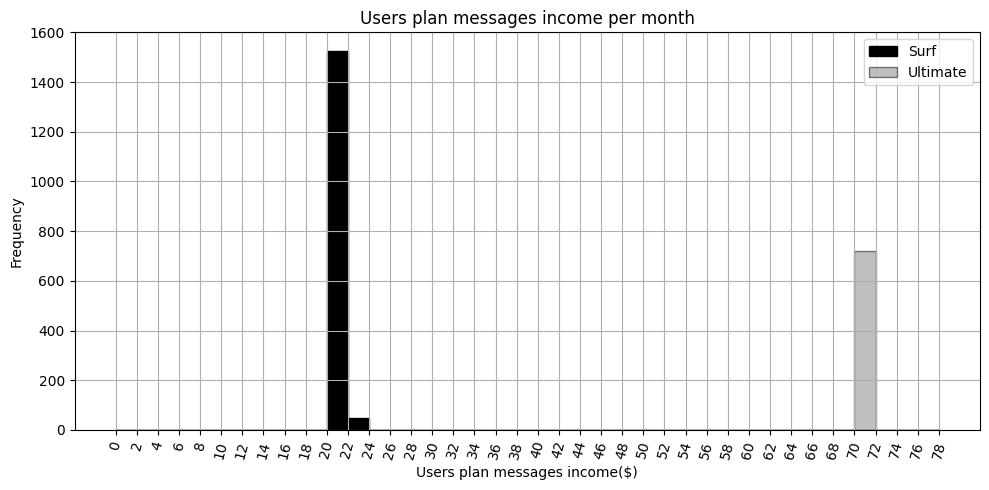

In [197]:
bins = np.arange(0, 80, 2)

plt.figure(figsize=(10, 5))

plt.hist(surf_messages_income, bins=bins, edgecolor='black', color='black', label='Surf')
plt.hist(ultimate_messages_income, bins=bins, edgecolor='black', alpha=0.5, color='grey', label='Ultimate')
plt.title('Users plan messages income per month')
plt.xlabel('Users plan messages income($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(0, 80, 2), rotation=75)
#plt.yticks(range(0, 1600, 100), rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

### 1.15.0.3. Internet Traffic Revenue

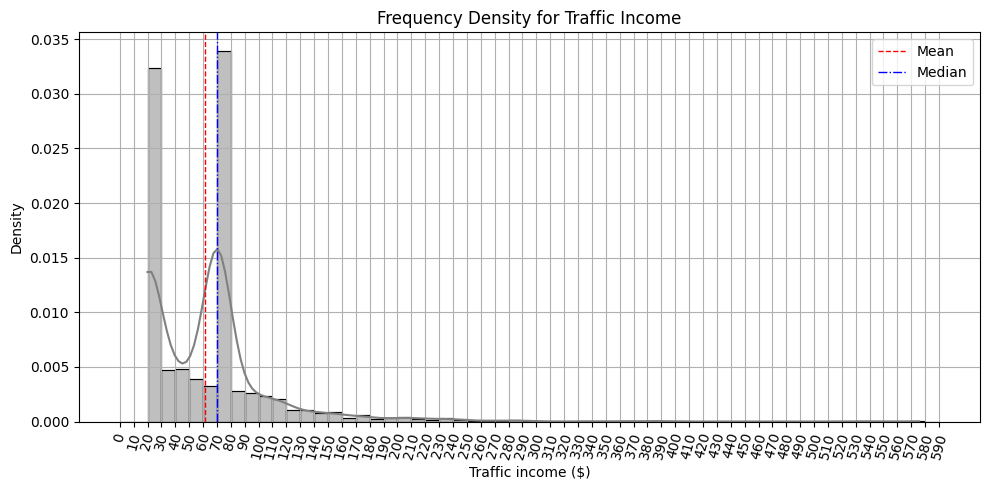

In [204]:
traffic = df_user_activity_per_month['traffic_income'].dropna()
mean = traffic.mean()
median = traffic.median()

bins = np.arange(0, 600, 10)

plt.figure(figsize=(10, 5))

sns.histplot(traffic, bins=bins, kde=True, stat="density", color='grey')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='blue', linestyle='-.', linewidth=1, label='Median')
plt.title('Frequency Density for Traffic Income')
plt.xlabel('Traffic income ($)')
plt.ylabel('Density')
plt.grid(True)
plt.xticks(range(0, 600, 10), rotation=75)
plt.legend()

plt.tight_layout()
plt.show()

In [205]:
# Compare the average traffic revenue consumed by each plan and by month. Plot a bar chart to visualize it.

df_median_income_traffic_per_plan_month = df_user_activity_per_month.pivot_table(index='plan', columns='month',
values='traffic_income', aggfunc='median')
print(df_median_income_traffic_per_plan_month)

month     2018-01  2018-02  2018-03  2018-04  2018-05  2018-06  2018-07  2018-08   2018-09  2018-10  2018-11   2018-12
plan                                                                                                                  
surf         20.0     20.0     20.0     20.0     20.0  21.1997  35.1657  35.1951  36.08935  41.0079  34.5383  43.62115
ultimate     70.0     70.0     70.0     70.0     70.0  70.0000  70.0000  70.0000  70.00000  70.0000  70.0000  70.00000


In [206]:
df_median_income_traffic_per_plan_month = df_median_income_traffic_per_plan_month.reset_index().melt(
    id_vars='plan',
    var_name='month',
    value_name='median_traffic_income'
)

print(df_median_income_traffic_per_plan_month)

        plan    month  median_traffic_income
0       surf  2018-01               20.00000
1   ultimate  2018-01               70.00000
2       surf  2018-02               20.00000
3   ultimate  2018-02               70.00000
4       surf  2018-03               20.00000
5   ultimate  2018-03               70.00000
6       surf  2018-04               20.00000
7   ultimate  2018-04               70.00000
8       surf  2018-05               20.00000
9   ultimate  2018-05               70.00000
10      surf  2018-06               21.19970
11  ultimate  2018-06               70.00000
12      surf  2018-07               35.16570
13  ultimate  2018-07               70.00000
14      surf  2018-08               35.19510
15  ultimate  2018-08               70.00000
16      surf  2018-09               36.08935
17  ultimate  2018-09               70.00000
18      surf  2018-10               41.00790
19  ultimate  2018-10               70.00000
20      surf  2018-11               34.53830
21  ultima

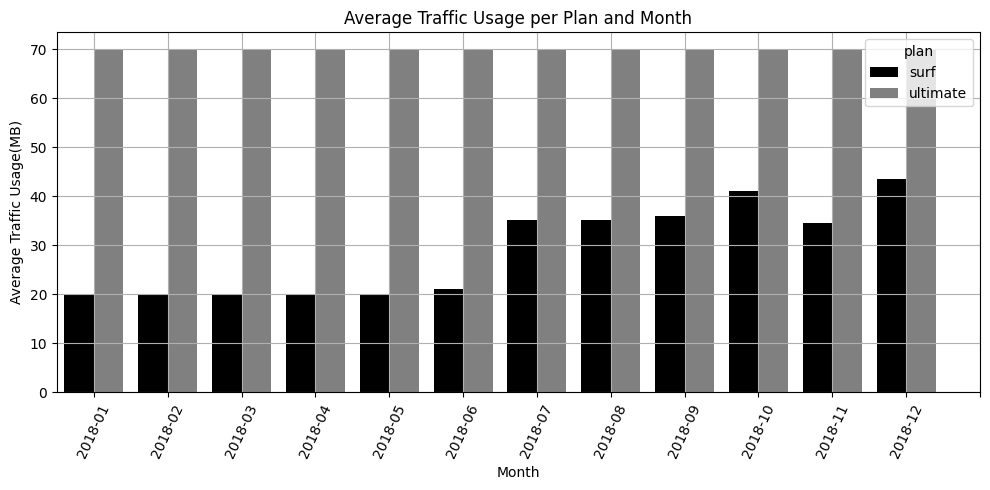

In [207]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_median_income_traffic_per_plan_month, x='month', y='median_traffic_income', hue='plan', palette=['black', 'grey'])

plt.xlabel('Month')
plt.ylabel('Average Traffic Usage(MB)')
plt.title('Average Traffic Usage per Plan and Month')
plt.grid(True)
plt.xticks(range(0, 13, 1), rotation=65)
plt.yticks(range(0, 75, 10))

plt.tight_layout()
plt.show()

In [208]:
surf_traffic_income = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'surf'), 'traffic_income']
ultimate_traffic_income = df_user_activity_per_month.loc[(df_user_activity_per_month['plan'] == 'ultimate'), 'traffic_income']

print(surf_traffic_income)
print()
print(ultimate_traffic_income)

1        20.0000
2        20.0000
3        89.7049
4        51.4430
5        60.0918
          ...   
2282    177.2849
2286     20.0000
2287     37.6826
2288     20.0000
2289     20.0000
Name: traffic_income, Length: 1573, dtype: float64

0        70.00000
19       70.00000
20       79.79174
26       70.00000
27       70.00000
          ...    
2284    112.07035
2285     70.00000
2290     70.00000
2291     70.00000
2292     70.00000
Name: traffic_income, Length: 720, dtype: float64


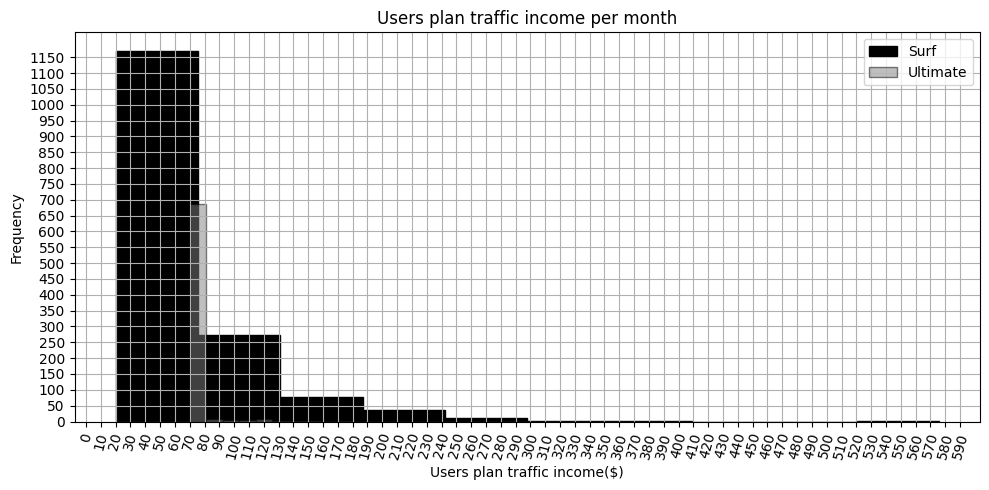

In [209]:
bins = np.arange(0, 600, 10)

plt.figure(figsize=(10, 5))

plt.hist(surf_traffic_income, edgecolor='black', color='black', label='Surf')
plt.hist(ultimate_traffic_income, edgecolor='black', alpha=0.5, color='grey', label='Ultimate')
plt.title('Users plan traffic income per month')
plt.xlabel('Users plan traffic income($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(0, 600, 10), rotation=75)
plt.yticks(range(0, 1200, 50), rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

[Draw conclusions about how revenue differs between plans.]

`LSPL`
> Regarding revenue, calling and messaging services do not show a significant revenue difference between plans, as most users stay within the limits included in the base rate. In contrast, the 'Surf' plan generates additional revenue from the internet traffic service due to the use of traffic above the limit. The 'Ultimate' plan, despite offering greater capacity, does not show any additional revenue, indicating that its benefits are underutilized by users.

### 1.15.0.4. Revenue by cities

In [210]:
print(df_user_activity_per_month['city'].value_counts())

city
new_york-newark-jersey_city_ny-nj-pa_msa          377
los_angeles-long_beach-anaheim_ca_msa             132
chicago-naperville-elgin_il-in-wi_msa              94
dallas-fort_worth-arlington_tx_msa                 88
philadelphia-camden-wilmington_pa-nj-de-md_msa     82
                                                 ... 
omaha-council_bluffs_ne-ia_msa                      3
jacksonville_fl_msa                                 2
el_paso_tx_msa                                      2
raleigh-cary_nc_msa                                 2
cape_coral-fort_myers_fl_msa                        1
Name: count, Length: 73, dtype: int64


In [211]:
df_city_income = df_user_activity_per_month.pivot_table(index='city', columns='plan', values='services_income', aggfunc='sum')
df_city_income = df_city_income.reset_index()

In [212]:
print(df_city_income.describe())

plan           surf     ultimate
count     71.000000    51.000000
mean    1288.278863  1018.826337
std     2134.753137   962.854813
min       20.000000    70.000000
25%      328.287200   490.000000
50%      824.762400   740.571720
75%     1670.269050  1085.000000
max    16951.876300  4857.349700


In [213]:
print(df_city_income.describe(include=['object']))

plan                              city
count                               73
unique                              73
top     albany-schenectady-troy_ny_msa
freq                                 1


In [214]:
min_income_surf_cities = df_city_income.loc[(df_city_income['surf'] == df_city_income['surf'].min()), :]
max_income_surf_cities = df_city_income.loc[(df_city_income['surf'] == df_city_income['surf'].max()), :]

min_income_ultimate_cities = df_city_income.loc[(df_city_income['ultimate'] == df_city_income['ultimate'].min()), :]
max_income_ultimate_cities = df_city_income.loc[(df_city_income['ultimate'] == df_city_income['ultimate'].max()), :]

In [215]:
print(min_income_surf_cities)
print()
print(max_income_surf_cities)
print()
print(min_income_ultimate_cities)
print()
print(max_income_ultimate_cities)

plan           city  surf  ultimate
68    tucson_az_msa  20.0     630.0

plan                                      city        surf   ultimate
43    new_york-newark-jersey_city_ny-nj-pa_msa  16951.8763  4857.3497

plan                                 city       surf  ultimate
3     austin-round_rock-georgetown_tx_msa  1221.5791      70.0
4                      bakersfield_ca_msa   319.9346      70.0
11           cape_coral-fort_myers_fl_msa        NaN      70.0

plan                                      city        surf   ultimate
43    new_york-newark-jersey_city_ny-nj-pa_msa  16951.8763  4857.3497


In [218]:
print(f"Lowest income cities:\nCity: '{min_income_surf_cities.iloc[0,0]}', Plan income (Surf): '{min_income_surf_cities.iloc[0, 1]}'\n")

for idx, row in min_income_ultimate_cities.iterrows():
    print(f"City: '{row['city']}', Plan income (Ultimate): '{row['ultimate']}'")

Lowest income cities:
City: 'tucson_az_msa', Plan income (Surf): '20.0'

City: 'austin-round_rock-georgetown_tx_msa', Plan income (Ultimate): '70.0'
City: 'bakersfield_ca_msa', Plan income (Ultimate): '70.0'
City: 'cape_coral-fort_myers_fl_msa', Plan income (Ultimate): '70.0'


In [217]:
print(f"Highest income cities:\nCity: '{max_income_surf_cities.iloc[0,0]}', Plan income (Surf): '{max_income_surf_cities.iloc[0, 1]}'")
print(f"City: '{max_income_ultimate_cities.iloc[0,0]}', Plan income (Ultimate): '{max_income_ultimate_cities.iloc[0,2]}'\n")

Highest income cities:
City: 'new_york-newark-jersey_city_ny-nj-pa_msa', Plan income (Surf): '16951.8763'
City: 'new_york-newark-jersey_city_ny-nj-pa_msa', Plan income (Ultimate): '4857.3497'



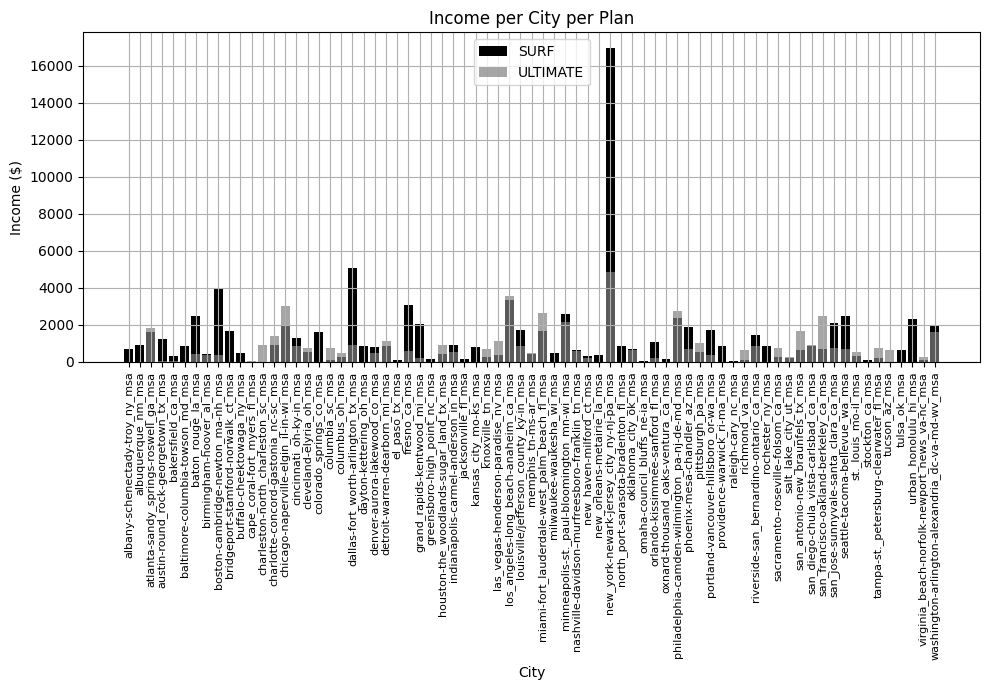

In [219]:
plt.figure(figsize=(10, 7))
plt.bar(df_city_income['city'], df_city_income['surf'], label='SURF', color='black')
plt.bar(df_city_income['city'], df_city_income['ultimate'], label='ULTIMATE', color='grey', alpha=0.7)

plt.xlabel('City')
plt.ylabel('Income ($)')
plt.title('Income per City per Plan')
plt.grid(True)
plt.xticks(range(len(df_city_income['city'])), df_city_income['city'], rotation=90, fontsize=8)
#plt.yticks(range(0, 75, 10))
plt.legend()

plt.tight_layout()
plt.show()

## Test statistical hypotheses

[Test the hypothesis that the average revenues from users of the Ultimate and Surf calling plans are different.]

In [220]:
print("> Total revenue from Megaline services: \n\n", df_user_activity_per_month["services_income"].describe())

> Total revenue from Megaline services: 

 count    2293.000000
mean       62.550346
std        46.427396
min        20.000000
25%        22.163900
50%        70.000000
75%        70.000000
max       594.353100
Name: services_income, dtype: float64


In [221]:
print("> Plan income (Surf) for Megaline services: \n\n", df_user_activity_per_month.loc[df_user_activity_per_month["plan"] == 'surf', 'services_income'].describe())

> Plan income (Surf) for Megaline services: 

 count    1573.000000
mean       58.148633
std        55.003591
min        20.000000
25%        20.000000
50%        36.889900
75%        78.177100
max       594.353100
Name: services_income, dtype: float64


In [222]:
print("> Plan income (Ultimate) for Megaline services: \n\n", df_user_activity_per_month.loc[df_user_activity_per_month["plan"] == 'ultimate', 'services_income'].describe())

> Plan income (Ultimate) for Megaline services: 

 count    720.000000
mean      72.166866
std       11.027300
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      181.127310
Name: services_income, dtype: float64


In [224]:
# Test the hypothesis that the average revenues from users of the Ultimate and Surf calling plans are different.

# 1. Propose Hypotheses H0, H1
# H0: Average revenues for the Sur and Ultimate plans are equal (==)
# H1: Average revenues for the Surf and Ultimate plans are different (!=)

surf_income = df_user_activity_per_month.loc[df_user_activity_per_month['plan'] == 'surf', 'services_income']
ultimate_income = df_user_activity_per_month.loc[df_user_activity_per_month['plan'] == 'ultimate', 'services_income']

# 2. Specify Significance or Confidence
# alpha = 5%
# confidence = 95%

alpha = 0.05

# 3. Calculate critical and test values, define acceptance zones, and Rejection

results = st.ttest_ind(ultimate_income, surf_income)
print(f"> Value (p): {results.pvalue:.15f}")

# 4. Decision and Conclusion

if results.pvalue < alpha:
    
    display(HTML("<b>The null hypothesis is rejected</b>, because there is statistical evidence that <b>the average incomes are different.</b>"))

else:
    
    display(HTML("<b>We cannot reject the null hypothesis</b>, because there is insufficient evidence to affirm that <b>the average incomes are different</b>"))

> Value (p): 0.000000000015677


In [225]:
print("> NY - NY area income for Megaline services: \n\n", df_user_activity_per_month.loc[df_user_activity_per_month["city"] == 'new_york-newark-jersey_city_ny-nj-pa_msa', 'services_income'].describe())

> NY - NY area income for Megaline services: 

 count    377.000000
mean      57.849406
std       43.081898
min       20.000000
25%       20.000000
50%       49.304300
75%       71.027400
max      285.646900
Name: services_income, dtype: float64


In [226]:
print("> Ingresos area NY - NY por servicios de Megaline: \n\n", df_user_activity_per_month.loc[df_user_activity_per_month["city"] != 'new_york-newark-jersey_city_ny-nj-pa_msa', 'services_income'].describe())

> Ingresos area NY - NY por servicios de Megaline: 

 count    1916.000000
mean       63.475322
std        47.012957
min        20.000000
25%        22.955900
50%        70.000000
75%        70.000000
max       594.353100
Name: services_income, dtype: float64


[Develop the null and alternative hypotheses, choose the statistical test, determine the alpha value.]

In [227]:
# Test the hypothesis that the average income of commuters in the NY-NJ area is different from that of commuters in other regions.

# 1. Propose Hypotheses H0, H1
# H0: Average incomes in the NY-NJ area and the rest of the areas are the same (==)
# H1: Average incomes in the NY-NJ area and the rest of the areas are different (!=)

ny_nj_income = df_user_activity_per_month[df_user_activity_per_month['city'] == 'new_york-newark-jersey_city_ny-nj-pa_msa']['services_income']
other_income = df_user_activity_per_month[df_user_activity_per_month['city'] != 'new_york-newark-jersey_city_ny-nj-pa_msa']['services_income']

# 2. Specify Significance or Confidence
# alpha = 5%
# confidence = 95%

alpha = 0.05

# 3. Calculate critical and test values, define acceptance and rejection zones

results = st.ttest_ind(ny_nj_income, other_income)
print(f"> Value (p): {results.pvalue:.15f}")

# 4. Decision and Conclusion

if results.pvalue < alpha:
    
    display(HTML("<b>The null hypothesis is rejected</b>, because there is statistical evidence that <b>the average incomes are different.</b>"))
else:
    
    display(HTML("<b>We cannot reject the null hypothesis</b>, because there is insufficient evidence to affirm that <b>the average incomes are different</b>"))

> Value (p): 0.031467575497101


### 1.17. Overall Conclusion

[In this final section, list your key conclusions. Make sure they cover all the important decisions (assumptions) you made that determined the way you chose to process and analyze the data.]

`LSPL`   
> After a thorough exploratory and statistical analysis of user behavior and the profitability of the Megaline plan, the following conclusions were reached:

1. User Behavior: Despite the differences in the limits included, Surf and Ultimate users show similar patterns in call, text, and internet usage. Surf users tend to exceed data limits more frequently, which contributes to generating additional revenue.

2. Plan Comparison: While the Ultimate plan offers more generous allowances, its added value is underutilized. The Surf plan generates more revenue from overages, especially in internet traffic.

3. Demographic patterns: The majority of high-consumption (and high-income) users are concentrated in the New York and Newark areas and are over 33 years old, suggesting professional or urban usage profiles.

4. Statistical hypothesis testing: The test between the average incomes of the Surf and Ultimate plans confirmed differences with a 95% confidence level. Therefore, there is a difference in usage behavior for Megaline services between Surf and Ultimate plan users, with the Surf plan generating the highest income for Megaline. Additionally, it was also found that the New York and New Jersey area generates more revenue than the rest of the areas where Megaline provides services.

Recommendation: Megaline could consider:

Promoting the Surf plan with incentives for heavy internet users.

Reevaluating the Ultimate plan's price or the benefits it offers to increase its perceived value.

Focus marketing strategies on urban centers like New York and New Jersey, where engagement and revenue are highest.